<a href="https://colab.research.google.com/github/sanjana-singamsetty/Finance-expense-tracker/blob/main/implementation_odf_models_ipynb.ipynb%20--%20final%20" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents

- [1. Loading Libraries and Data](#loading-libraries-and-data)
- [2. Starting to Cleaning and Reading Data](#starting-to-cleaning-and-reading-data)
- [3. Drop Impractical Columns](#drop-impractical-columns)
- [4. Removing Outliers (Sales)](#removing-outliers-sales)
- [5. Prepare for Time-Series](#prepare-for-time-series)
- [6. Exploring Data (Numerical & Categorical)](#exploring-data-numerical--categorical)
- [7. Exploring Time-Series Charts](#exploring-time-series-charts)
  - [7.1 Visualize the Time Series (Line Plot)](#visualize-the-time-series-line-plot)
  - [7.2 Rolling Mean](#rolling-mean)
  - [7.3 Decomposition (Separating Trend, Seasonality, and Residuals)](#decomposition-separating-trend-seasonality-and-residuals)
  - [7.4 Seasonal Plots: Comparing Sales Across Different Time Periods](#seasonal-plots-comparing-sales-across-different-time-periods)
  - [7.5 Stationarity Check](#stationarity-check)
  - [7.6 Autocorrelation and Partial Autocorrelation](#autocorrelation-and-partial-autocorrelation)
  - [7.7 Feature Impacts](#feature-impacts)
- [8. Modelling](#modelling)
  - [8.1 ARIMA](#arima)
  - [8.2 SARIMA](#sarima)
  - [8.3 FB Prophet](#fb-prophet)



# 1. Loading Libraries and Data
<a id="loading-libraries-and-data"></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install sweetviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 60.9 MB/s eta 0:00:00


In [ ]:
!pip install Prophet

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from scipy import stats
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zahraaalaatageldein/sales-for-furniture-store")

print("Path to dataset files:", path)

100%|██████████| 124k/124k [00:00<00:00, 34.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/zahraaalaatageldein/sales-for-furniture-store/versions/2


In [ ]:
import os

# Define the directory path
dir_path = "/root/.cache/kagglehub/datasets/zahraaalaatageldein/sales-for-furniture-store/versions/2"

# List all files in the directory
files = os.listdir(dir_path)

# Print the file names
print(files)


['Super_Store_data.csv']


In [ ]:
import pandas as pd

# Define the file path
file_path = "/root/.cache/kagglehub/datasets/zahraaalaatageldein/sales-for-furniture-store/versions/2/Super_Store_data.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Display the first few rows
print(df.head())


   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
3       6  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   
4      11  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   

     Customer Name   Segment        Country             City  ... Postal Code  \
0      Claire Gute  Consumer  United States        Henderson  ...       42420   
1      Claire Gute  Consumer  United States        Henderson  ...       42420   
2   Sean O'Donnell  Consumer  United States  Fort Lauderdale  ...       33311   
3  Brosina Hoffman  Consumer  United States      Los Angeles  ...       90032   
4  Brosina Hoffman  Consumer  United States      Los Angeles  ...       90032   

   Region       Product ID

In [ ]:
df

Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
0          1  CA-2016-152156   11/8/2016  11/11/2016    Second Class   
1          2  CA-2016-152156   11/8/2016  11/11/2016    Second Class   
2          4  US-2015-108966  10/11/2015  10/18/2015  Standard Class   
3          6  CA-2014-115812    6/9/2014   6/14/2014  Standard Class   
4         11  CA-2014-115812    6/9/2014   6/14/2014  Standard Class   
...      ...             ...         ...         ...             ...   
2116    9963  CA-2015-168088   3/19/2015   3/22/2015     First Class   
2117    9965  CA-2016-146374   12/5/2016  12/10/2016    Second Class   
2118    9981  US-2015-151435    9/6/2015    9/9/2015    Second Class   
2119    9990  CA-2014-110422   1/21/2014   1/23/2014    Second Class   
2120    9991  CA-2017-121258   2/26/2017    3/3/2017  Standard Class   

     Customer ID     Customer Name      Segment        Country  \
0       CG-12520       Claire Gute     Consumer  United States   
1       CG-12520       Claire Gute     Consumer  United States   
2       SO-20335    Sean O'Donnell     Consumer  United States   
3       BH-11710   Brosina Hoffman     Consumer  United States   
4       BH-11710   Brosina Hoffman     Consumer  United States   
...          ...               ...          ...            ...   
2116    CM-12655  Corinna Mitchell  Home Office  United States   
2117    HE-14800      Harold Engle    Corporate  United States   
2118    SW-20455       Shaun Weien     Consumer  United States   
2119    TB-21400  Tom Boeckenhauer     Consumer  United States   
2120    DB-13060       Dave Brooks     Consumer  United States   

                 City  ... Postal Code   Region       Product ID   Category  \
0           Henderson  ...       42420    South  FUR-BO-10001798  Furniture   
1           Henderson  ...       42420    South  FUR-CH-10000454  Furniture   
2     Fort Lauderdale  ...       33311    South  FUR-TA-10000577  Furniture   
3         Los Angeles  ...       90032     West  FUR-FU-10001487  Furniture   
4         Los Angeles  ...       90032     West  FUR-TA-10001539  Furniture   
...               ...  ...         ...      ...              ...        ...   
2116          Houston  ...       77041  Central  FUR-BO-10004218  Furniture   
2117           Newark  ...       19711     East  FUR-FU-10002671  Furniture   
2118        Lafayette  ...       70506    South  FUR-TA-10001039  Furniture   
2119            Miami  ...       33180    South  FUR-FU-10001889  Furniture   
2120       Costa Mesa  ...       92627     West  FUR-FU-10000747  Furniture   

     Sub-Category                                       Product Name  \
0       Bookcases                  Bush Somerset Collection Bookcase   
1          Chairs  Hon Deluxe Fabric Upholstered Stacking Chairs,...   
2          Tables      Bretford CR4500 Series Slim Rectangular Table   
3     Furnishings  Eldon Expressions Wood and Plastic Desk Access...   
4          Tables           Chromcraft Rectangular Conference Tables   
...           ...                                                ...   
2116    Bookcases  Bush Heritage Pine Collection 5-Shelf Bookcase...   
2117  Furnishings  Electrix 20W Halogen Replacement Bulb for Zoom...   
2118       Tables                         KI Adjustable-Height Table   
2119  Furnishings                             Ultra Door Pull Handle   
2120  Furnishings  Tenex B1-RE Series Chair Mats for Low Pile Car...   

          Sales  Quantity  Discount    Profit  
0      261.9600         2      0.00   41.9136  
1      731.9400         3      0.00  219.5820  
2      957.5775         5      0.45 -383.0310  
3       48.8600         7      0.00   14.1694  
4     1706.1840         9      0.20   85.3092  
...         ...       ...       ...       ...  
2116   383.4656         4      0.32  -67.6704  
2117    13.4000         1      0.00    6.4320  
2118    85.9800         1      0.00   22.3548  
2119    25.2480         3      0.20    4.1028  
2120  

# 2. Starting to Clean and Read Data
<a id="starting-to-cleaning-and-reading-data"></a>

In [ ]:
report = sv.analyze(df)
report.show_html('report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
def comprehensive_df_overview(dataframe):
    print("##### Shape")
    print(dataframe.shape)
    print("\n##### Data Types")
    print(dataframe.dtypes)
    print("\n##### Columns")
    print(dataframe.columns)
    print("\n##### Index")
    print(dataframe.index)
    print("\n##### Head")
    print(dataframe.head())
    print("\n##### Tail")
    print(dataframe.tail())
    print("\n##### NA")
    print(dataframe.isnull().values.any())
    print("\n##### NA Sum - Ratio")
    print(pd.DataFrame({"na_sum": dataframe.isnull().sum(), "ratio": dataframe.isnull().sum() / dataframe.shape[0]}))

    numeric_cols = dataframe.select_dtypes(include=['number']).columns
    if not numeric_cols.empty:
        print("\n##### Basic Statistics (Numeric Columns)")
        print(dataframe[numeric_cols].describe().T)
        print("\n##### Skewness (Numeric Columns)")
        print(dataframe[numeric_cols].skew())
        print("\n##### Kurtosis (Numeric Columns)")
        print(dataframe[numeric_cols].kurtosis())
        print("\n##### Correlation Matrix (Numeric Columns)")
        print(dataframe[numeric_cols].corr())
    else:
        print("\nNo numeric columns found for statistical analysis.")

    non_numeric_cols = dataframe.select_dtypes(exclude=['number']).columns
    if not non_numeric_cols.empty:
        print("\n##### Basic Statistics (Non-Numeric Columns)")
        print(dataframe[non_numeric_cols].describe().T)
    else:
        print("\nNo non-numeric columns found for statistical analysis.")

    print("\n##### Unique Values per Column")
    print(dataframe.nunique())
    print("\n##### Sample Rows")
    print(dataframe.sample(5))
    print("\n##### Memory Usage")
    print(dataframe.memory_usage(deep=True))

comprehensive_df_overview(df)

##### Shape
(2121, 21)

##### Data Types
Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

##### Columns
Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

##### Index
RangeIndex(start=0, stop=2121, step=1)

##### Head
   Row ID        Order ID  Orde

# 3. Drop Impractical Columns
<a id="drop-impractical-columns"></a>

In [ ]:
drop_cols = ["Row ID", "Segment", "Country", "Postal Code", "Customer Name","Region"]
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

In [ ]:
df

Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0     CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1     CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2     US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
3     CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   
4     CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   
...              ...         ...         ...             ...         ...   
2116  CA-2015-168088   3/19/2015   3/22/2015     First Class    CM-12655   
2117  CA-2016-146374   12/5/2016  12/10/2016    Second Class    HE-14800   
2118  US-2015-151435    9/6/2015    9/9/2015    Second Class    SW-20455   
2119  CA-2014-110422   1/21/2014   1/23/2014    Second Class    TB-21400   
2120  CA-2017-121258   2/26/2017    3/3/2017  Standard Class    DB-13060   

                 City       State       Product ID   Category Sub-Category  \
0           Henderson    Kentucky  FUR-BO-10001798  Furniture    Bookcases   
1           Henderson    Kentucky  FUR-CH-10000454  Furniture       Chairs   
2     Fort Lauderdale     Florida  FUR-TA-10000577  Furniture       Tables   
3         Los Angeles  California  FUR-FU-10001487  Furniture  Furnishings   
4         Los Angeles  California  FUR-TA-10001539  Furniture       Tables   
...               ...         ...              ...        ...          ...   
2116          Houston       Texas  FUR-BO-10004218  Furniture    Bookcases   
2117           Newark    Delaware  FUR-FU-10002671  Furniture  Furnishings   
2118        Lafayette   Louisiana  FUR-TA-10001039  Furniture       Tables   
2119            Miami     Florida  FUR-FU-10001889  Furniture  Furnishings   
2120       Costa Mesa  California  FUR-FU-10000747  Furniture  Furnishings   

                                           Product Name      Sales  Quantity  \
0                     Bush Somerset Collection Bookcase   261.9600         2   
1     Hon Deluxe Fabric Upholstered Stacking Chairs,...   731.9400         3   
2         Bretford CR4500 Series Slim Rectangular Table   957.5775         5   
3     Eldon Expressions Wood and Plastic Desk Access...    48.8600         7   
4              Chromcraft Rectangular Conference Tables  1706.1840         9   
...                                                 ...        ...       ...   
2116  Bush Heritage Pine Collection 5-Shelf Bookcase...   383.4656         4   
2117  Electrix 20W Halogen Replacement Bulb for Zoom...    13.4000         1   
2118                         KI Adjustable-Height Table    85.9800         1   
2119                             Ultra Door Pull Handle    25.2480         3   
2120  Tenex B1-RE Series Chair Mats for Low Pile Car...    91.9600         2   

      Discount    Profit  
0         0.00   41.9136  
1         0.00  219.5820  
2         0.45 -383.0310  
3         0.00   14.1694  
4         0.20   85.3092  
...        ...       ...  
2116      0.32  -67.6704  
2117      0.00    6.4320  
2118      0.00   22.3548  
2119      0.20    4.1028  
2120      0.00   15.6332  

[2121 rows x 15 columns]

# 4. Removing Outliers (Sales)
<a id="removing-outliers-sales"></a>

In [ ]:
def handle_outliers(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[[column]].dropna()))
    df = df[(z_scores < threshold).all(axis=1)]

    return df

In [ ]:
df = handle_outliers(df, "Sales")

In [ ]:
df

Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0     CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1     CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2     US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
3     CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   
4     CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   
...              ...         ...         ...             ...         ...   
2116  CA-2015-168088   3/19/2015   3/22/2015     First Class    CM-12655   
2117  CA-2016-146374   12/5/2016  12/10/2016    Second Class    HE-14800   
2118  US-2015-151435    9/6/2015    9/9/2015    Second Class    SW-20455   
2119  CA-2014-110422   1/21/2014   1/23/2014    Second Class    TB-21400   
2120  CA-2017-121258   2/26/2017    3/3/2017  Standard Class    DB-13060   

                 City       State       Product ID   Category Sub-Category  \
0           Henderson    Kentucky  FUR-BO-10001798  Furniture    Bookcases   
1           Henderson    Kentucky  FUR-CH-10000454  Furniture       Chairs   
2     Fort Lauderdale     Florida  FUR-TA-10000577  Furniture       Tables   
3         Los Angeles  California  FUR-FU-10001487  Furniture  Furnishings   
4         Los Angeles  California  FUR-TA-10001539  Furniture       Tables   
...               ...         ...              ...        ...          ...   
2116          Houston       Texas  FUR-BO-10004218  Furniture    Bookcases   
2117           Newark    Delaware  FUR-FU-10002671  Furniture  Furnishings   
2118        Lafayette   Louisiana  FUR-TA-10001039  Furniture       Tables   
2119            Miami     Florida  FUR-FU-10001889  Furniture  Furnishings   
2120       Costa Mesa  California  FUR-FU-10000747  Furniture  Furnishings   

                                           Product Name      Sales  Quantity  \
0                     Bush Somerset Collection Bookcase   261.9600         2   
1     Hon Deluxe Fabric Upholstered Stacking Chairs,...   731.9400         3   
2         Bretford CR4500 Series Slim Rectangular Table   957.5775         5   
3     Eldon Expressions Wood and Plastic Desk Access...    48.8600         7   
4              Chromcraft Rectangular Conference Tables  1706.1840         9   
...                                                 ...        ...       ...   
2116  Bush Heritage Pine Collection 5-Shelf Bookcase...   383.4656         4   
2117  Electrix 20W Halogen Replacement Bulb for Zoom...    13.4000         1   
2118                         KI Adjustable-Height Table    85.9800         1   
2119                             Ultra Door Pull Handle    25.2480         3   
2120  Tenex B1-RE Series Chair Mats for Low Pile Car...    91.9600         2   

      Discount    Profit  
0         0.00   41.9136  
1         0.00  219.5820  
2         0.45 -383.0310  
3         0.00   14.1694  
4         0.20   85.3092  
...        ...       ...  
2116      0.32  -67.6704  
2117      0.00    6.4320  
2118      0.00   22.3548  
2119      0.20    4.1028  
2120      0.00   15.6332  

[2076 rows x 15 columns]

# 5. Prepare for Time-Series
<a id="prepare-for-time-series"></a>

In [ ]:
def prepare_for_timeseries(dataframe):
    # Convert 'Order Date' column to datetime format
    dataframe = dataframe.copy()  # Avoid SettingWithCopyWarning
    dataframe.loc[:, 'Date'] = pd.to_datetime(dataframe['Order Date'], format='%m/%d/%Y', errors='coerce')

    # Sort dataframe by the new 'Date' column
    dataframe = dataframe.sort_values(by='Date')

    # Reset the index after sorting
    dataframe.reset_index(drop=True, inplace=True)

    # Print information about the data preparation
    print("##### Data Preparation Completed")
    print("\n##### Sorted DataFrame Head")
    print(dataframe.head())

    return dataframe

# Apply the function to your dataframe
df = prepare_for_timeseries(df)


##### Data Preparation Completed

##### Sorted DataFrame Head
         Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0  CA-2014-105417   1/7/2014  1/12/2014  Standard Class    VS-21820   
1  CA-2014-149020  1/10/2014  1/15/2014  Standard Class    AJ-10780   
2  CA-2014-130092  1/11/2014  1/14/2014     First Class    SV-20365   
3  CA-2014-109232  1/13/2014  1/16/2014    Second Class    ND-18370   
4  CA-2014-157147  1/13/2014  1/18/2014  Standard Class    BD-11605   

             City           State       Product ID   Category Sub-Category  \
0      Huntsville           Texas  FUR-FU-10004864  Furniture  Furnishings   
1     Springfield        Virginia  FUR-FU-10000965  Furniture  Furnishings   
2           Dover        Delaware  FUR-FU-10000010  Furniture  Furnishings   
3  Mount Pleasant  South Carolina  FUR-CH-10000422  Furniture       Chairs   
4   San Francisco      California  FUR-BO-10003034  Furniture    Bookcases   

                                        Pr

In [ ]:
df

Order ID  Order Date  Ship Date       Ship Mode Customer ID  \
0     CA-2014-105417    1/7/2014  1/12/2014  Standard Class    VS-21820   
1     CA-2014-149020   1/10/2014  1/15/2014  Standard Class    AJ-10780   
2     CA-2014-130092   1/11/2014  1/14/2014     First Class    SV-20365   
3     CA-2014-109232   1/13/2014  1/16/2014    Second Class    ND-18370   
4     CA-2014-157147   1/13/2014  1/18/2014  Standard Class    BD-11605   
...              ...         ...        ...             ...         ...   
2071  US-2017-158526  12/29/2017   1/1/2018    Second Class    KH-16360   
2072  US-2017-158526  12/29/2017   1/1/2018    Second Class    KH-16360   
2073  US-2017-158526  12/29/2017   1/1/2018    Second Class    KH-16360   
2074  CA-2017-130631  12/29/2017   1/2/2018  Standard Class    BS-11755   
2075  CA-2017-143259  12/30/2017   1/3/2018  Standard Class    PO-18865   

                City           State       Product ID   Category Sub-Category  \
0         Huntsville           Texas  FUR-FU-10004864  Furniture  Furnishings   
1        Springfield        Virginia  FUR-FU-10000965  Furniture  Furnishings   
2              Dover        Delaware  FUR-FU-10000010  Furniture  Furnishings   
3     Mount Pleasant  South Carolina  FUR-CH-10000422  Furniture       Chairs   
4      San Francisco      California  FUR-BO-10003034  Furniture    Bookcases   
...              ...             ...              ...        ...          ...   
2071      Louisville        Kentucky  FUR-CH-10002602  Furniture       Chairs   
2072      Louisville        Kentucky  FUR-CH-10004495  Furniture       Chairs   
2073      Louisville        Kentucky  FUR-CH-10001270  Furniture       Chairs   
2074         Edmonds      Washington  FUR-FU-10004093  Furniture  Furnishings   
2075   New York City        New York  FUR-BO-10003441  Furniture    Bookcases   

                                           Product Name     Sales  Quantity  \
0     Howard Miller 14-1/2" Diameter Chrome Round Wa...    76.728         3   
1     Howard Miller 11-1/2" Diameter Ridgewood Wall ...    51.940         1   
2       DAX Value U-Channel Document Frames, Easel Back     9.940         2   
3            Global Highback Leather Tilter in Burgundy   545.940         6   
4         O'Sullivan Elevations Bookcase, Cherry Finish   333.999         3   
...                                                 ...       ...       ...   
2071  DMI Arturo Collection Mission-style Design Woo...  1207.840         8   
2072      Global Leather and Oak Executive Chair, Black   300.980         1   
2073              Harbour Creations Steel Folding Chair   258.750         3   
2074            Hand-Finished Solid Wood Document Frame    68.460         2   
2075  Bush Westfield Collection Bookcases, Fully Ass...   323.136         4   

      Discount    Profit       Date  
0         0.60  -53.7096 2014-01-07  
1         0.00   21.2954 2014-01-10  
2         0.00    3.0814 2014-01-11  
3         0.00   87.3504 2014-01-13  
4         0.15    3.9294 2014-01-13  
...        ...       ...        ...  
2071      0.00  314.0384 2017-12-29  
2072      0.00   87.2842 2017-12-29  
2073      0.00   77.6250 2017-12-29  
2074      0.00   20.5380 2017-12-29  
2075      0.20   12.1176 2017-12-30  

[2076 rows x 16 columns]

# 6. Exploring Data (Numerical & Categorical)
<a id="exploring-data"></a>

In [ ]:
def fetch_col_names(dataframe):
    # Categorical columns: columns with object dtype
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'O']

    # Numerical columns: columns with non-object dtype
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    return cat_cols, num_cols

cat_cols, num_cols = fetch_col_names(df)

In [ ]:
cat_cols

['Order ID',
 'Order Date',
 'Ship Date',
 'Ship Mode',
 'Customer ID',
 'City',
 'State',
 'Product ID',
 'Category',
 'Sub-Category',
 'Product Name']

In [ ]:
num_cols

['Sales', 'Quantity', 'Discount', 'Profit', 'Date']

In [ ]:
def cat_details(dataframe, col_name, plot=False):
    # Count and ratio of unique values
    value_counts = dataframe[col_name].value_counts()
    ratio = 100 * value_counts / len(dataframe)

    # Calculate the length of the summary line
    summary_length = len(col_name) + len(" Details ")
    border_length = max(50, summary_length + 4)

    # Create border lines
    top_border = '#' * border_length
    middle_border = f"{'#' * 10} {col_name} Details {'#' * 10}".center(border_length, '#')
    bottom_border = '#' * border_length

    # Print summary
    print(f"\n{top_border}")
    print(middle_border)
    print(pd.DataFrame({col_name: value_counts, "Ratio (%)": ratio}))
    print(f"\n{col_name} has {dataframe[col_name].nunique()} unique values.")
    print(f"{bottom_border}\n")

    # Plot count plot if plot is True
    if plot:
        plt.figure(figsize=(10, 6))
        plt.bar(value_counts.index, value_counts.values)
        plt.title(f"Count Plot for {col_name}")
        plt.xlabel(col_name)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()


##################################################
################ Order ID Details ################
                Order ID  Ratio (%)
Order ID                           
US-2015-138121         4   0.192678
US-2015-129007         4   0.192678
CA-2015-104346         4   0.192678
CA-2017-125451         4   0.192678
CA-2014-145387         4   0.192678
...                  ...        ...
CA-2015-124058         1   0.048170
CA-2015-116484         1   0.048170
CA-2015-163965         1   0.048170
CA-2015-112305         1   0.048170
CA-2017-143259         1   0.048170

[1734 rows x 2 columns]

Order ID has 1734 unique values.
##################################################



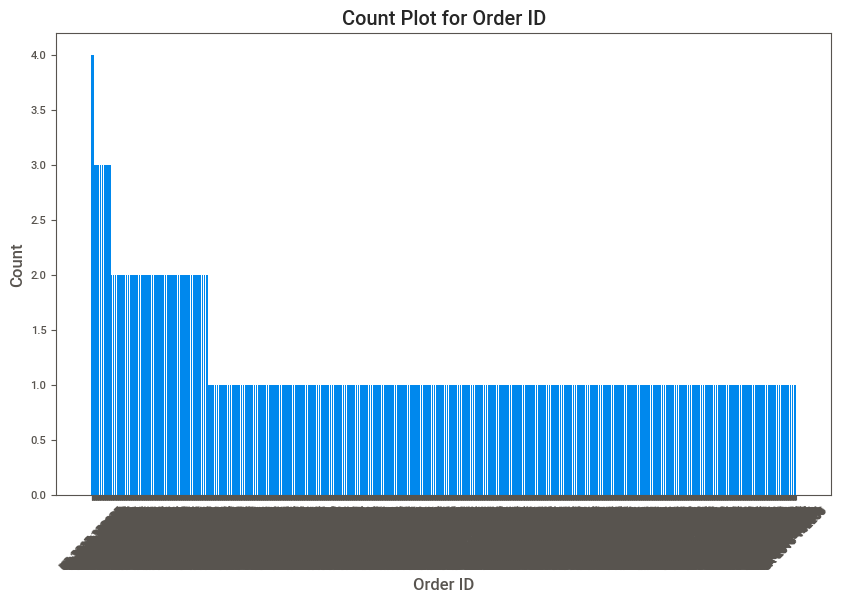


##################################################
############### Order Date Details ###############
            Order Date  Ratio (%)
Order Date                       
9/5/2016            10   0.481696
10/30/2017           9   0.433526
11/19/2017           9   0.433526
12/1/2016            9   0.433526
11/18/2014           8   0.385356
...                ...        ...
11/24/2015           1   0.048170
11/22/2015           1   0.048170
11/19/2015           1   0.048170
11/15/2015           1   0.048170
12/30/2017           1   0.048170

[882 rows x 2 columns]

Order Date has 882 unique values.
##################################################



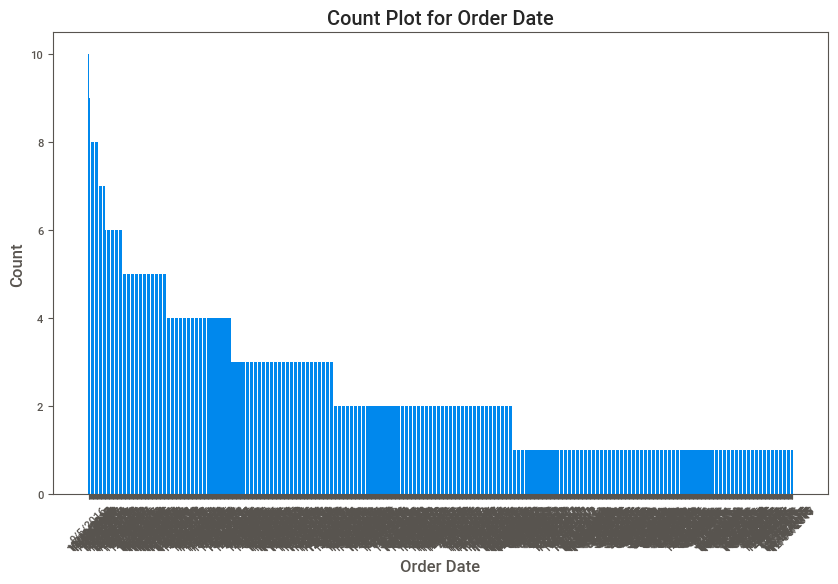


##################################################
############### Ship Date Details ################
            Ship Date  Ratio (%)
Ship Date                       
12/6/2017          10   0.481696
12/16/2015         10   0.481696
10/24/2017          9   0.433526
9/22/2016           8   0.385356
9/14/2016           8   0.385356
...               ...        ...
12/23/2015          1   0.048170
1/1/2016            1   0.048170
1/5/2016            1   0.048170
1/7/2016            1   0.048170
1/3/2018            1   0.048170

[952 rows x 2 columns]

Ship Date has 952 unique values.
##################################################



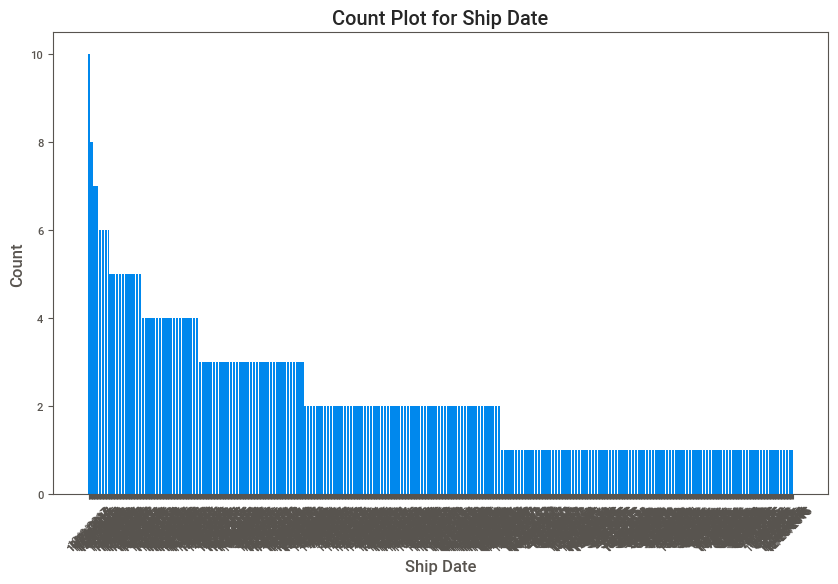


##################################################
############### Ship Mode Details ################
                Ship Mode  Ratio (%)
Ship Mode                           
Standard Class       1223  58.911368
Second Class          414  19.942197
First Class           322  15.510597
Same Day              117   5.635838

Ship Mode has 4 unique values.
##################################################



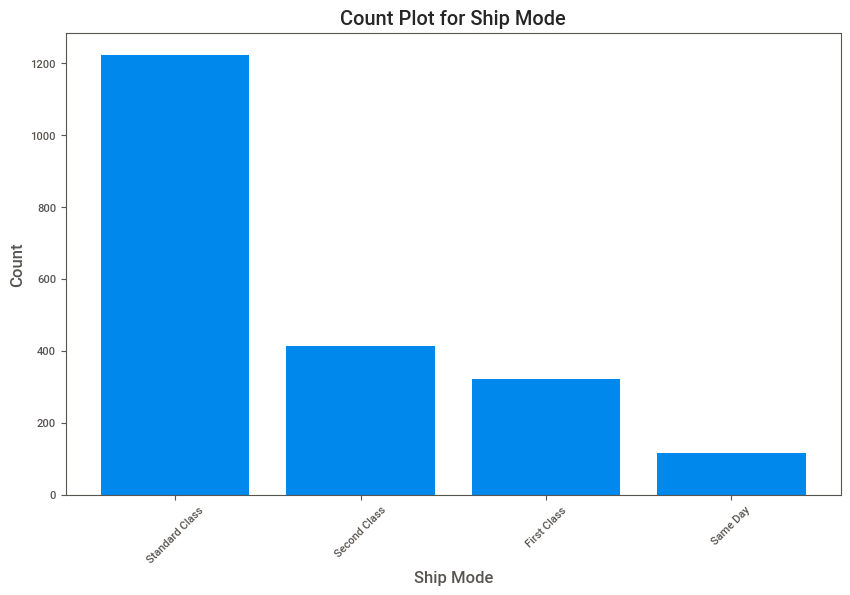


##################################################
############## Customer ID Details ###############
             Customer ID  Ratio (%)
Customer ID                        
SV-20365              13   0.626204
KL-16555               9   0.433526
LC-16885               9   0.433526
JE-15745               8   0.385356
GB-14530               8   0.385356
...                  ...        ...
MV-18190               1   0.048170
SC-20575               1   0.048170
FO-14305               1   0.048170
SW-20755               1   0.048170
GH-14665               1   0.048170

[702 rows x 2 columns]

Customer ID has 702 unique values.
##################################################



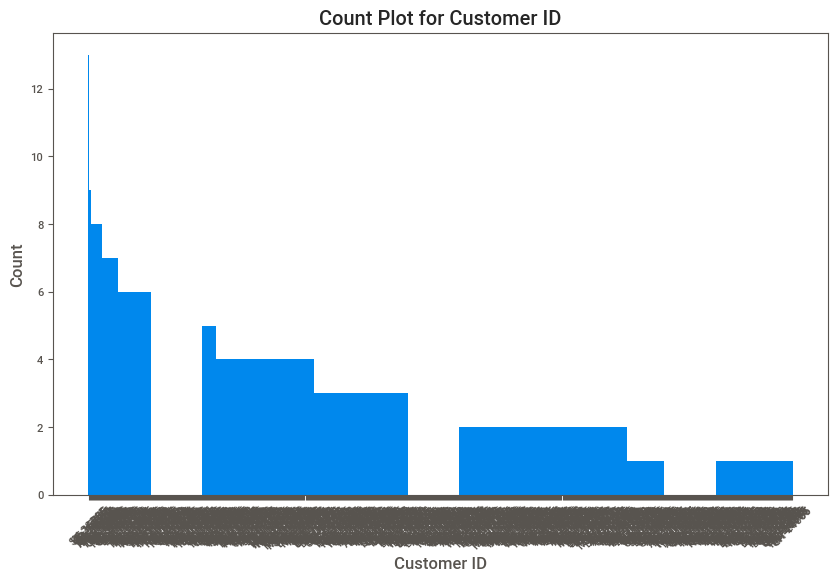


##################################################
################## City Details ##################
                City  Ratio (%)
City                           
New York City    184   8.863198
Los Angeles      151   7.273603
Philadelphia     108   5.202312
San Francisco    101   4.865125
Seattle           91   4.383430
...              ...        ...
Boise              1   0.048170
Port Arthur        1   0.048170
Lake Elsinore      1   0.048170
Champaign          1   0.048170
Hendersonville     1   0.048170

[368 rows x 2 columns]

City has 368 unique values.
##################################################



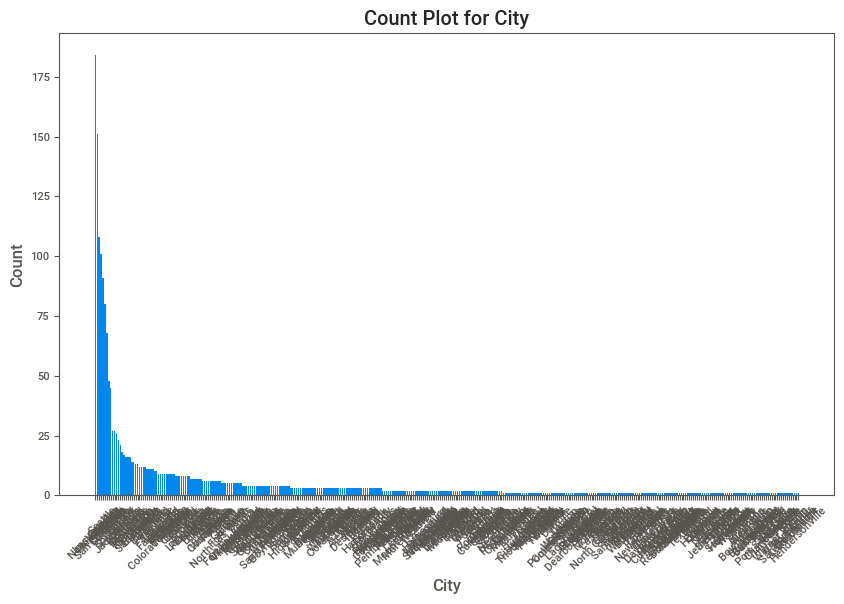


##################################################
################# State Details ##################
                      State  Ratio (%)
State                                 
California              437  21.050096
New York                227  10.934489
Texas                   200   9.633911
Illinois                123   5.924855
Pennsylvania            122   5.876686
Washington              107   5.154143
Ohio                     93   4.479769
Florida                  84   4.046243
Colorado                 51   2.456647
Virginia                 50   2.408478
Arizona                  49   2.360308
Michigan                 49   2.360308
Tennessee                43   2.071291
North Carolina           41   1.974952
Massachusetts            33   1.589595
Georgia                  32   1.541426
Wisconsin                30   1.445087
Kentucky                 29   1.396917
Maryland                 28   1.348748
New Jersey               25   1.204239
Indiana                  21   1.011561


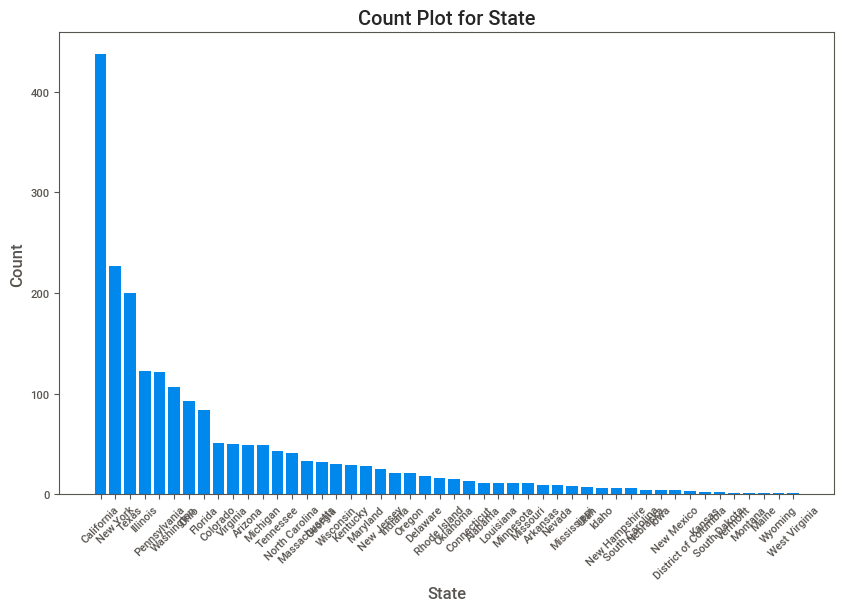


##################################################
############### Product ID Details ###############
                 Product ID  Ratio (%)
Product ID                            
FUR-FU-10004270          16   0.770713
FUR-CH-10001146          15   0.722543
FUR-CH-10002647          15   0.722543
FUR-CH-10003774          14   0.674374
FUR-FU-10001473          14   0.674374
...                     ...        ...
FUR-FU-10002874           1   0.048170
FUR-FU-10003095           1   0.048170
FUR-BO-10001567           1   0.048170
FUR-TA-10001691           1   0.048170
FUR-BO-10002206           1   0.048170

[375 rows x 2 columns]

Product ID has 375 unique values.
##################################################



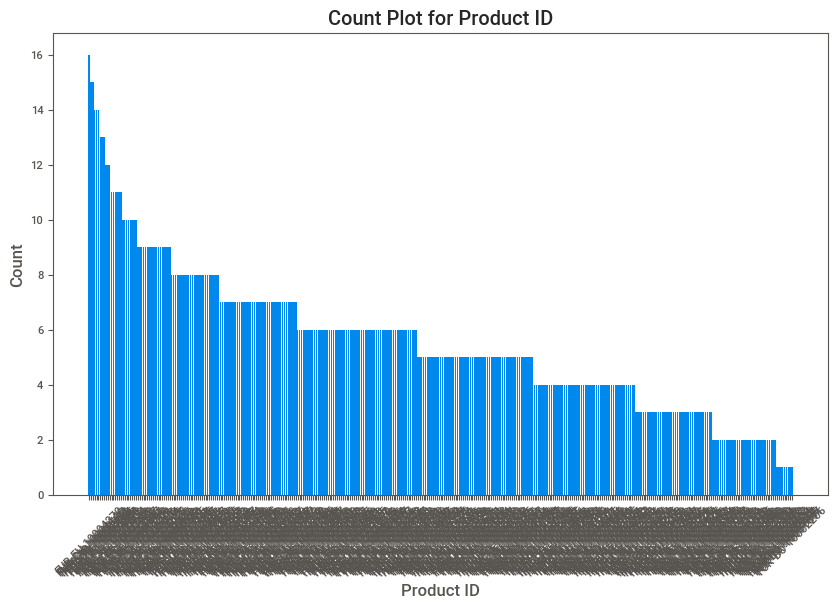


##################################################
################ Category Details ################
           Category  Ratio (%)
Category                      
Furniture      2076      100.0

Category has 1 unique values.
##################################################



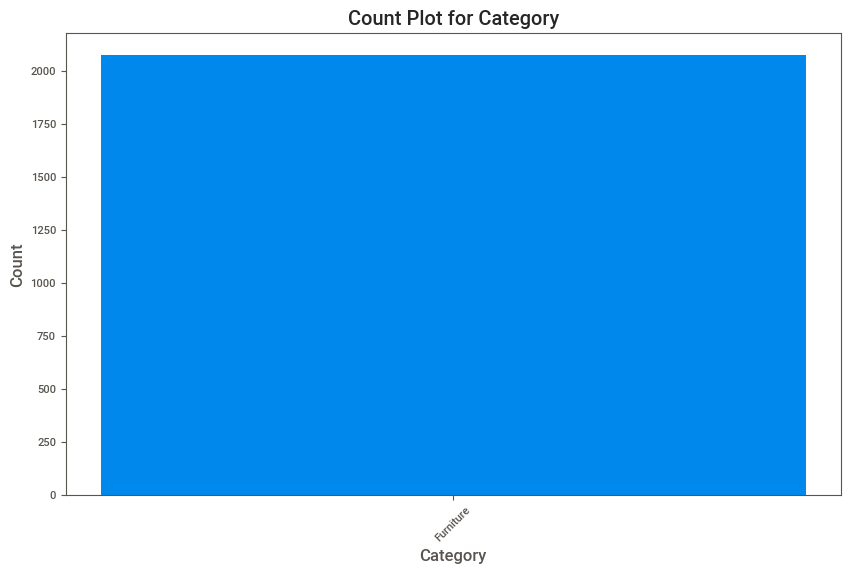


##################################################
############## Sub-Category Details ##############
              Sub-Category  Ratio (%)
Sub-Category                         
Furnishings            957  46.098266
Chairs                 596  28.709056
Tables                 303  14.595376
Bookcases              220  10.597303

Sub-Category has 4 unique values.
##################################################



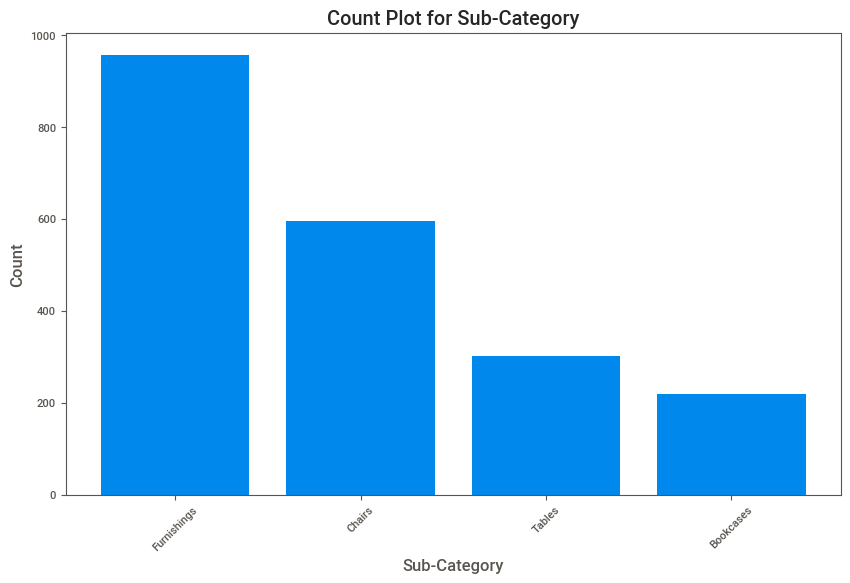


##################################################
############## Product Name Details ##############
                                                    Product Name  Ratio (%)
Product Name                                                               
KI Adjustable-Height Table                                    18   0.867052
Staple-based wall hangings                                    16   0.770713
Situations Contoured Folding Chairs, 4/Set                    15   0.722543
Eldon Wave Desk Accessories                                   14   0.674374
Global High-Back Leather Tilter, Burgundy                     14   0.674374
...                                                          ...        ...
Ultra Commercial Grade Dual Valve Door Closer                  1   0.048170
Linden 12" Wall Clock With Oak Frame                           1   0.048170
Bush Westfield Collection Bookcases, Dark Cherr...             1   0.048170
Barricks Non-Folding Utility Table with Steel L...           

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 136 (\x88) missing from font(s) Roboto.
  fig.canvas.print_figure(bytes_io, **kw)


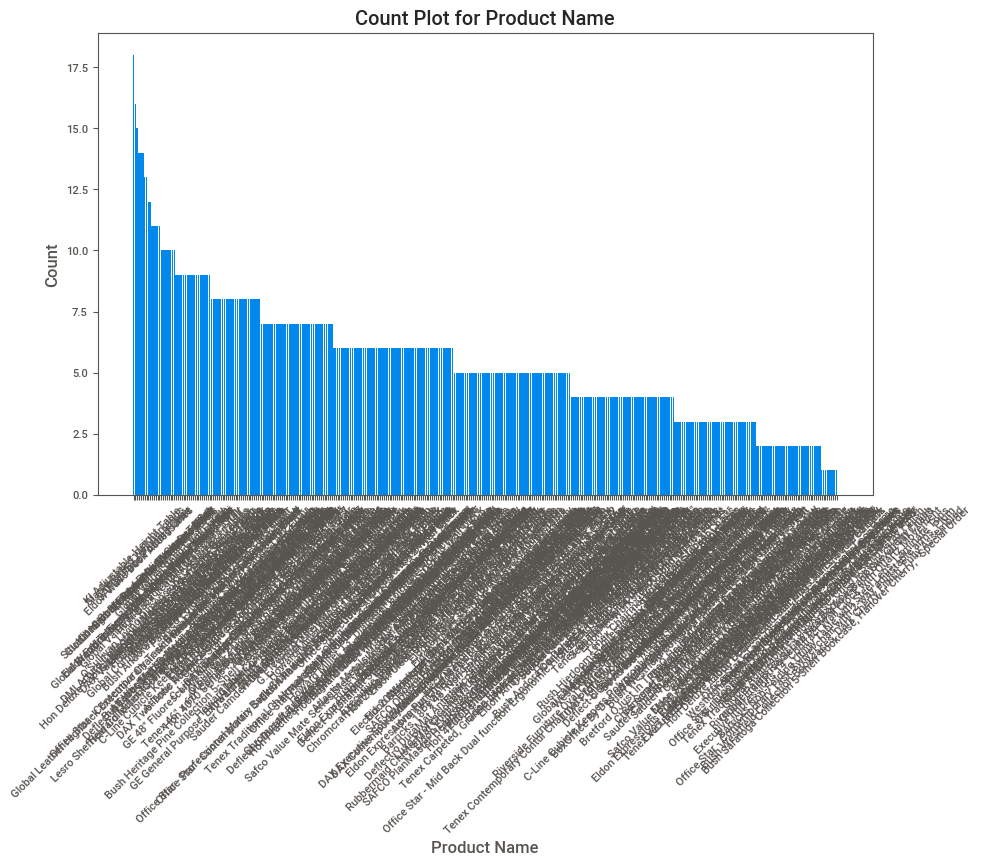

In [ ]:
for col in ['Order ID',
 'Order Date',
 'Ship Date',
 'Ship Mode',
 'Customer ID',
 'City',
 'State',
 'Product ID',
 'Category',
 'Sub-Category',
 'Product Name']:
    cat_details(df, col, plot=True)

In [ ]:
def num_details(dataframe, col_name, plot=False, quantiles=[0.05, 0.10, 0.20, 0.50, 0.60, 0.80, 0.90, 0.95, 0.99]):
    if plot:
        dataframe[col_name].hist(bins=20)
        plt.xlabel(col_name)
        plt.title(col_name)
        plt.show(block=True)

    # Calculate the length of the summary line
    summary_length = len(col_name) + len(" Details ")
    border_length = max(50, summary_length + 4)

    # Create border lines
    top_border = '#' * border_length
    middle_border = f"{'#' * 10} {col_name} Details {'#' * 10}".center(border_length, '#')
    bottom_border = '#' * border_length

    # Print summary
    print(f"\n{top_border}")
    print(middle_border)
    print(dataframe[col_name].describe(percentiles=quantiles).T, end="\n\n")
    print(f"{bottom_border}\n")

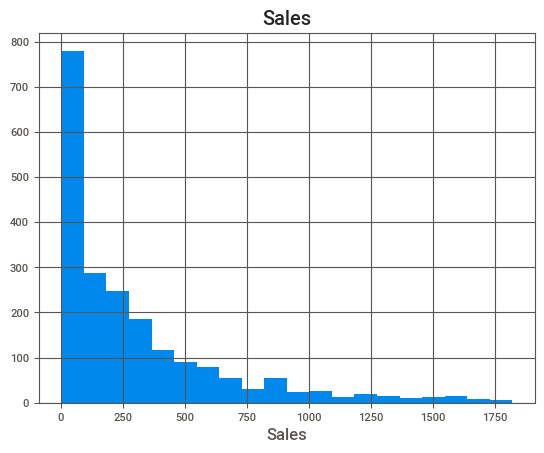


##################################################
################# Sales Details ##################
count    2076.000000
mean      298.785063
std       352.370405
min         1.892000
5%          9.975000
10%        17.056000
20%        33.110000
50%       173.224000
60%       241.960000
80%       510.240000
90%       801.568000
95%      1057.425000
99%      1588.230000
max      1819.860000
Name: Sales, dtype: float64

##################################################



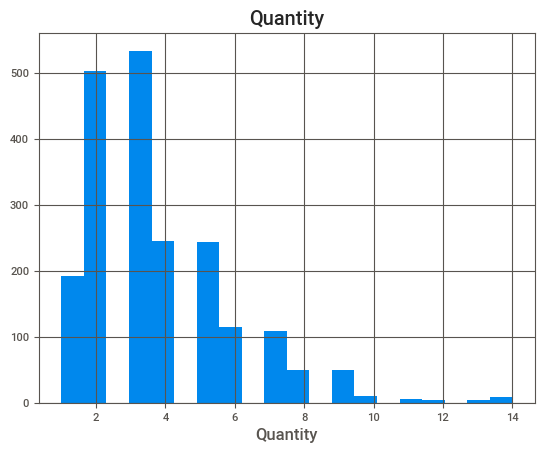


##################################################
################ Quantity Details ################
count    2076.000000
mean        3.702312
std         2.180751
min         1.000000
5%          1.000000
10%         2.000000
20%         2.000000
50%         3.000000
60%         4.000000
80%         5.000000
90%         7.000000
95%         8.000000
99%        11.000000
max        14.000000
Name: Quantity, dtype: float64

##################################################



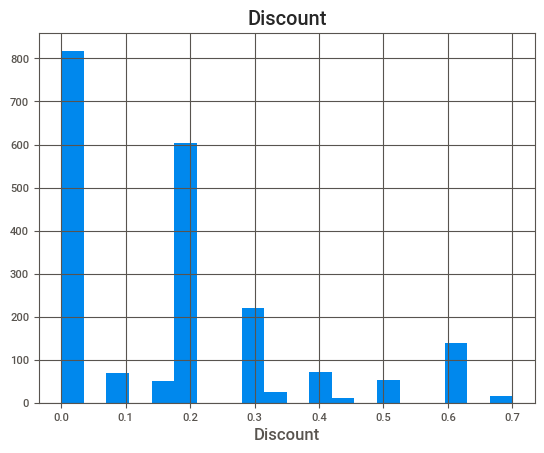


##################################################
################ Discount Details ################
count    2076.000000
mean        0.174721
std         0.182252
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
50%         0.200000
60%         0.200000
80%         0.300000
90%         0.450000
95%         0.600000
99%         0.600000
max         0.700000
Name: Discount, dtype: float64

##################################################



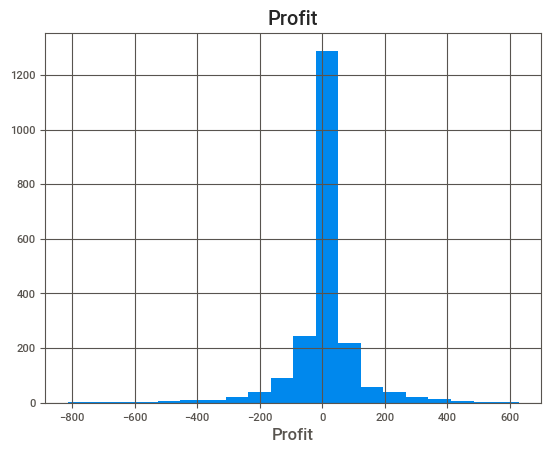


##################################################
################# Profit Details #################
count    2076.000000
mean        6.248290
std       105.158374
min      -814.483200
5%       -147.889875
10%       -77.143300
20%       -22.238800
50%         7.514000
60%        12.990000
80%        41.996500
90%        87.317300
95%       158.936400
99%       322.589925
max       629.010000
Name: Profit, dtype: float64

##################################################



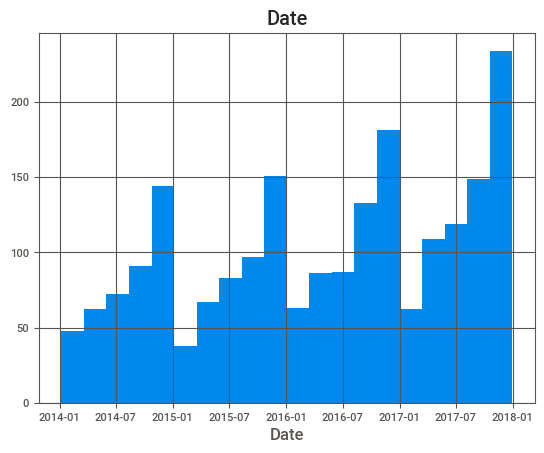


##################################################
################## Date Details ##################
count                             2076
mean     2016-04-30 07:50:58.959537664
min                2014-01-07 00:00:00
5%                 2014-05-25 18:00:00
10%                2014-09-08 12:00:00
20%                2015-01-04 00:00:00
50%                2016-06-20 12:00:00
60%                2016-11-03 00:00:00
80%                2017-07-16 00:00:00
90%                2017-10-30 00:00:00
95%                2017-12-01 00:00:00
99%                2017-12-24 00:00:00
max                2017-12-30 00:00:00
Name: Date, dtype: object

##################################################



In [ ]:
for col in num_cols:
    num_details(df, col, plot=True)

# 7. Exploring Time-Series Charts
<a id="exploring-time-series-charts"></a>

## 7.1 Visualize the Time Series (Line Plot)
<a id="visualize-time-series"></a>

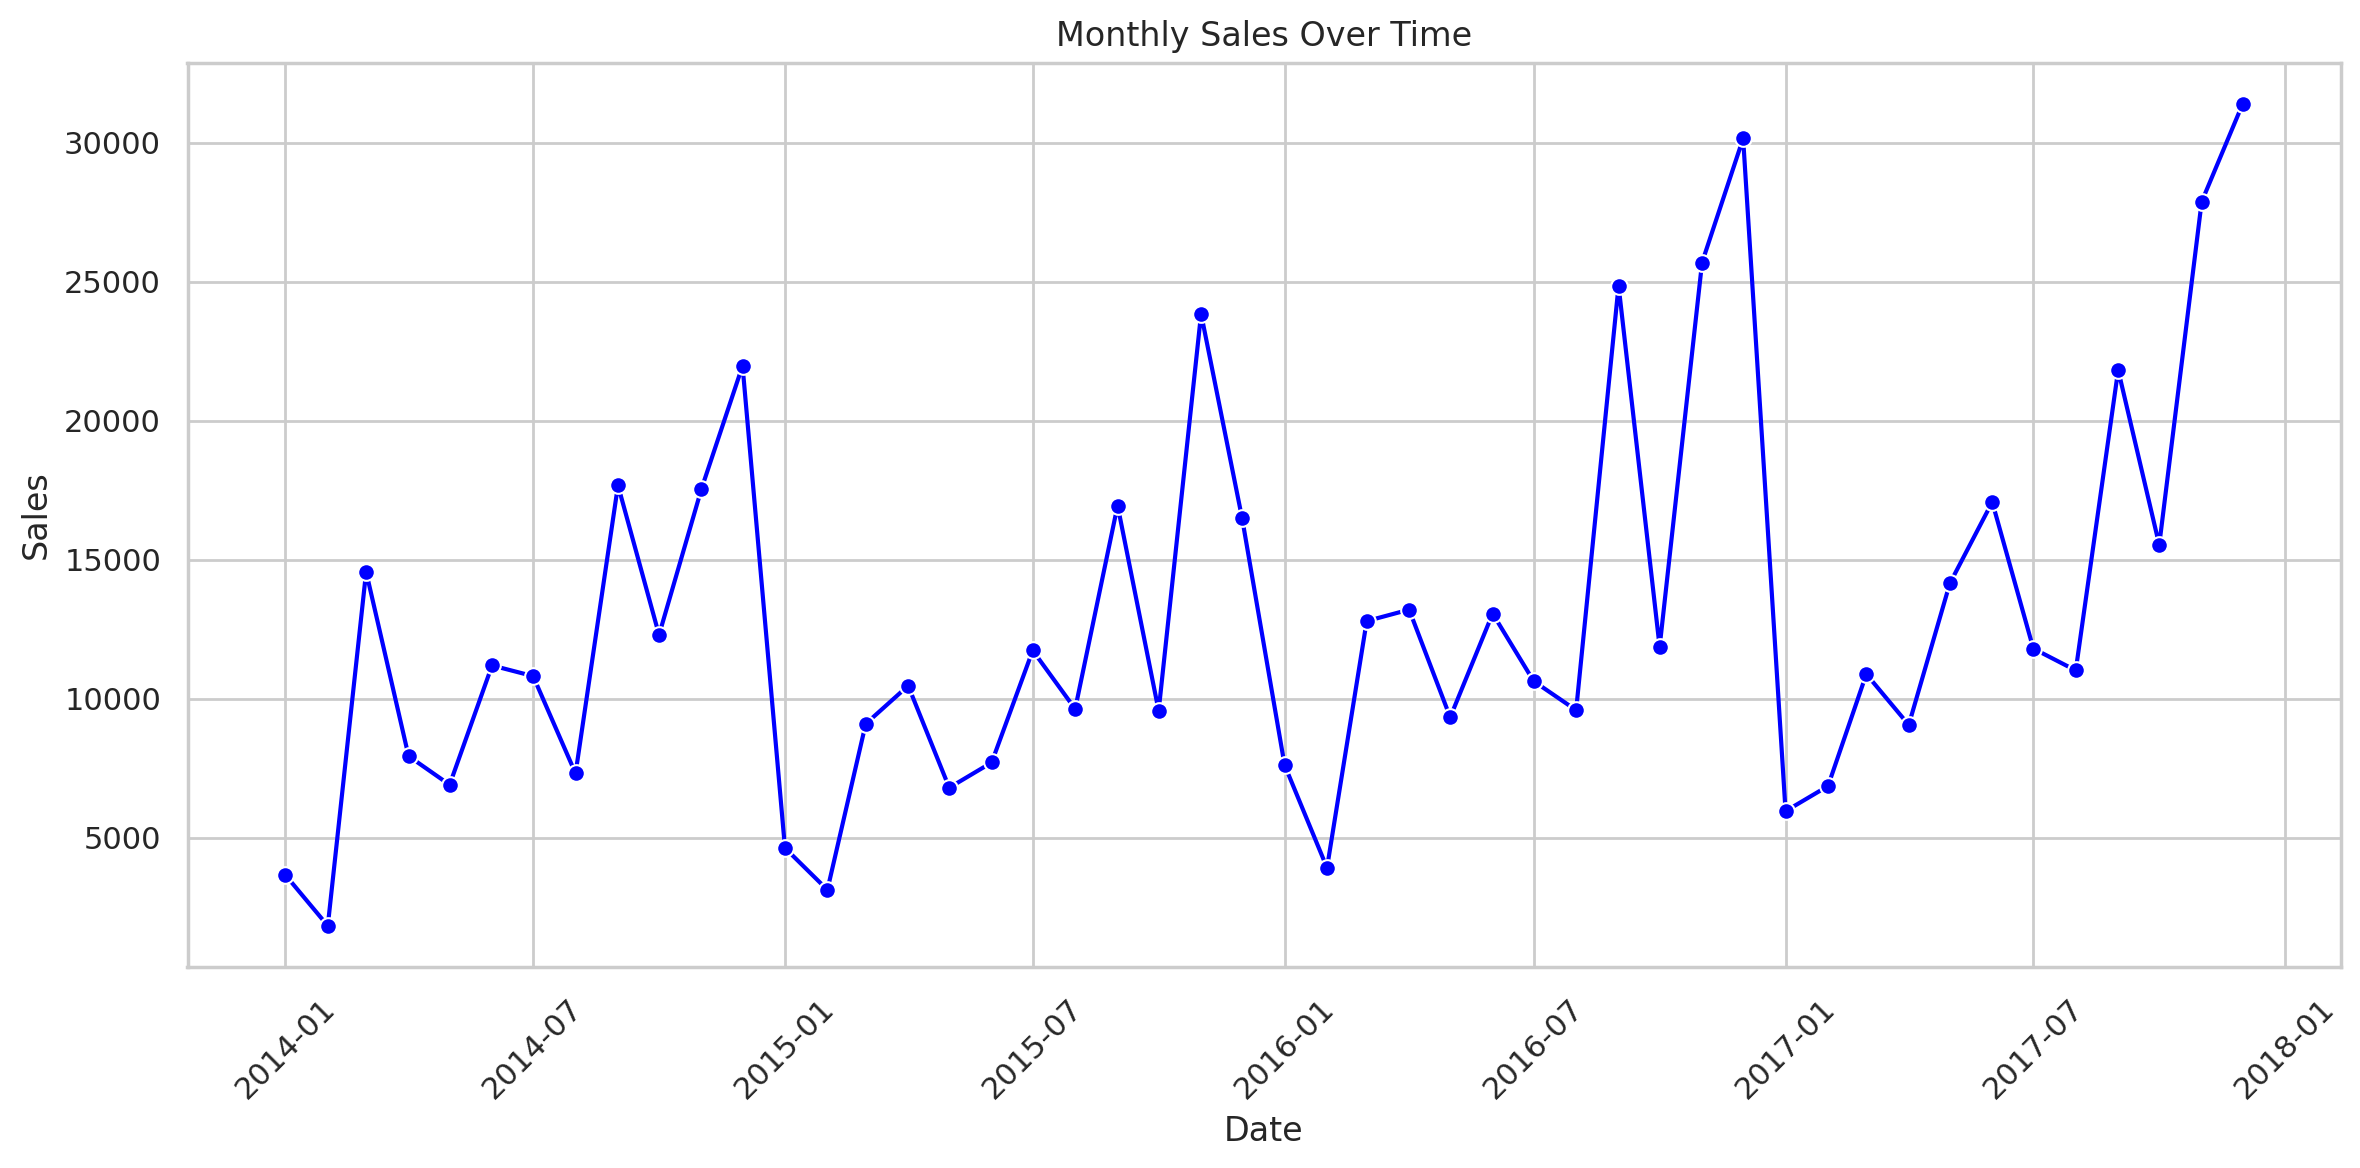

In [ ]:
# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract 'month' from 'Date'
df['month'] = df['Date'].dt.to_period('M')

# Group by 'month' and sum the 'Sales'
mdf = df.groupby('month')['Sales'].sum()

# Convert the grouped data to a DataFrame
mdf = pd.DataFrame(mdf)

# Create a time index (using a simple range)
mdf['time'] = np.arange(len(mdf.index))

# Set plot style
sns.set(style='whitegrid')

# Create figure
plt.figure(figsize=(12, 6), dpi=200)

# Ensure the index is a Timestamp for plotting
if isinstance(mdf.index, pd.PeriodIndex):
    mdf.index = mdf.index.to_timestamp()

# Create the line plot for 'Sales' over time
sns.lineplot(data=mdf, x=mdf.index, y='Sales', marker='o', color='blue')

# Labels and Title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Sales Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
df

Order ID  Order Date  Ship Date       Ship Mode Customer ID  \
0     CA-2014-105417    1/7/2014  1/12/2014  Standard Class    VS-21820   
1     CA-2014-149020   1/10/2014  1/15/2014  Standard Class    AJ-10780   
2     CA-2014-130092   1/11/2014  1/14/2014     First Class    SV-20365   
3     CA-2014-109232   1/13/2014  1/16/2014    Second Class    ND-18370   
4     CA-2014-157147   1/13/2014  1/18/2014  Standard Class    BD-11605   
...              ...         ...        ...             ...         ...   
2071  US-2017-158526  12/29/2017   1/1/2018    Second Class    KH-16360   
2072  US-2017-158526  12/29/2017   1/1/2018    Second Class    KH-16360   
2073  US-2017-158526  12/29/2017   1/1/2018    Second Class    KH-16360   
2074  CA-2017-130631  12/29/2017   1/2/2018  Standard Class    BS-11755   
2075  CA-2017-143259  12/30/2017   1/3/2018  Standard Class    PO-18865   

                City           State       Product ID   Category Sub-Category  \
0         Huntsville           Texas  FUR-FU-10004864  Furniture  Furnishings   
1        Springfield        Virginia  FUR-FU-10000965  Furniture  Furnishings   
2              Dover        Delaware  FUR-FU-10000010  Furniture  Furnishings   
3     Mount Pleasant  South Carolina  FUR-CH-10000422  Furniture       Chairs   
4      San Francisco      California  FUR-BO-10003034  Furniture    Bookcases   
...              ...             ...              ...        ...          ...   
2071      Louisville        Kentucky  FUR-CH-10002602  Furniture       Chairs   
2072      Louisville        Kentucky  FUR-CH-10004495  Furniture       Chairs   
2073      Louisville        Kentucky  FUR-CH-10001270  Furniture       Chairs   
2074         Edmonds      Washington  FUR-FU-10004093  Furniture  Furnishings   
2075   New York City        New York  FUR-BO-10003441  Furniture    Bookcases   

                                           Product Name     Sales  Quantity  \
0     Howard Miller 14-1/2" Diameter Chrome Round Wa...    76.728         3   
1     Howard Miller 11-1/2" Diameter Ridgewood Wall ...    51.940         1   
2       DAX Value U-Channel Document Frames, Easel Back     9.940         2   
3            Global Highback Leather Tilter in Burgundy   545.940         6   
4         O'Sullivan Elevations Bookcase, Cherry Finish   333.999         3   
...                                                 ...       ...       ...   
2071  DMI Arturo Collection Mission-style Design Woo...  1207.840         8   
2072      Global Leather and Oak Executive Chair, Black   300.980         1   
2073              Harbour Creations Steel Folding Chair   258.750         3   
2074            Hand-Finished Solid Wood Document Frame    68.460         2   
2075  Bush Westfield Collection Bookcases, Fully Ass...   323.136         4   

      Discount    Profit       Date    month  
0         0.60  -53.7096 2014-01-07  2014-01  
1         0.00   21.2954 2014-01-10  2014-01  
2         0.00    3.0814 2014-01-11  2014-01  
3         0.00   87.3504 2014-01-13  2014-01  
4         0.15    3.9294 2014-01-13  2014-01  
...        ...       ...        ...      ...  
2071      0.00  314.0384 2017-12-29  2017-12  
2072      0.00   87.2842 2017-12-29  2017-12  
2073      0.00   77.6250 2017-12-29  2017-12  
2074      0.00   20.5380 2017-12-29  2017-12  
2075      0.20   12.1176 2017-12-30  2017-12  

[2076 rows x 17 columns]

7.2 Rolling Mean
<a id="rolling-mean"></a>

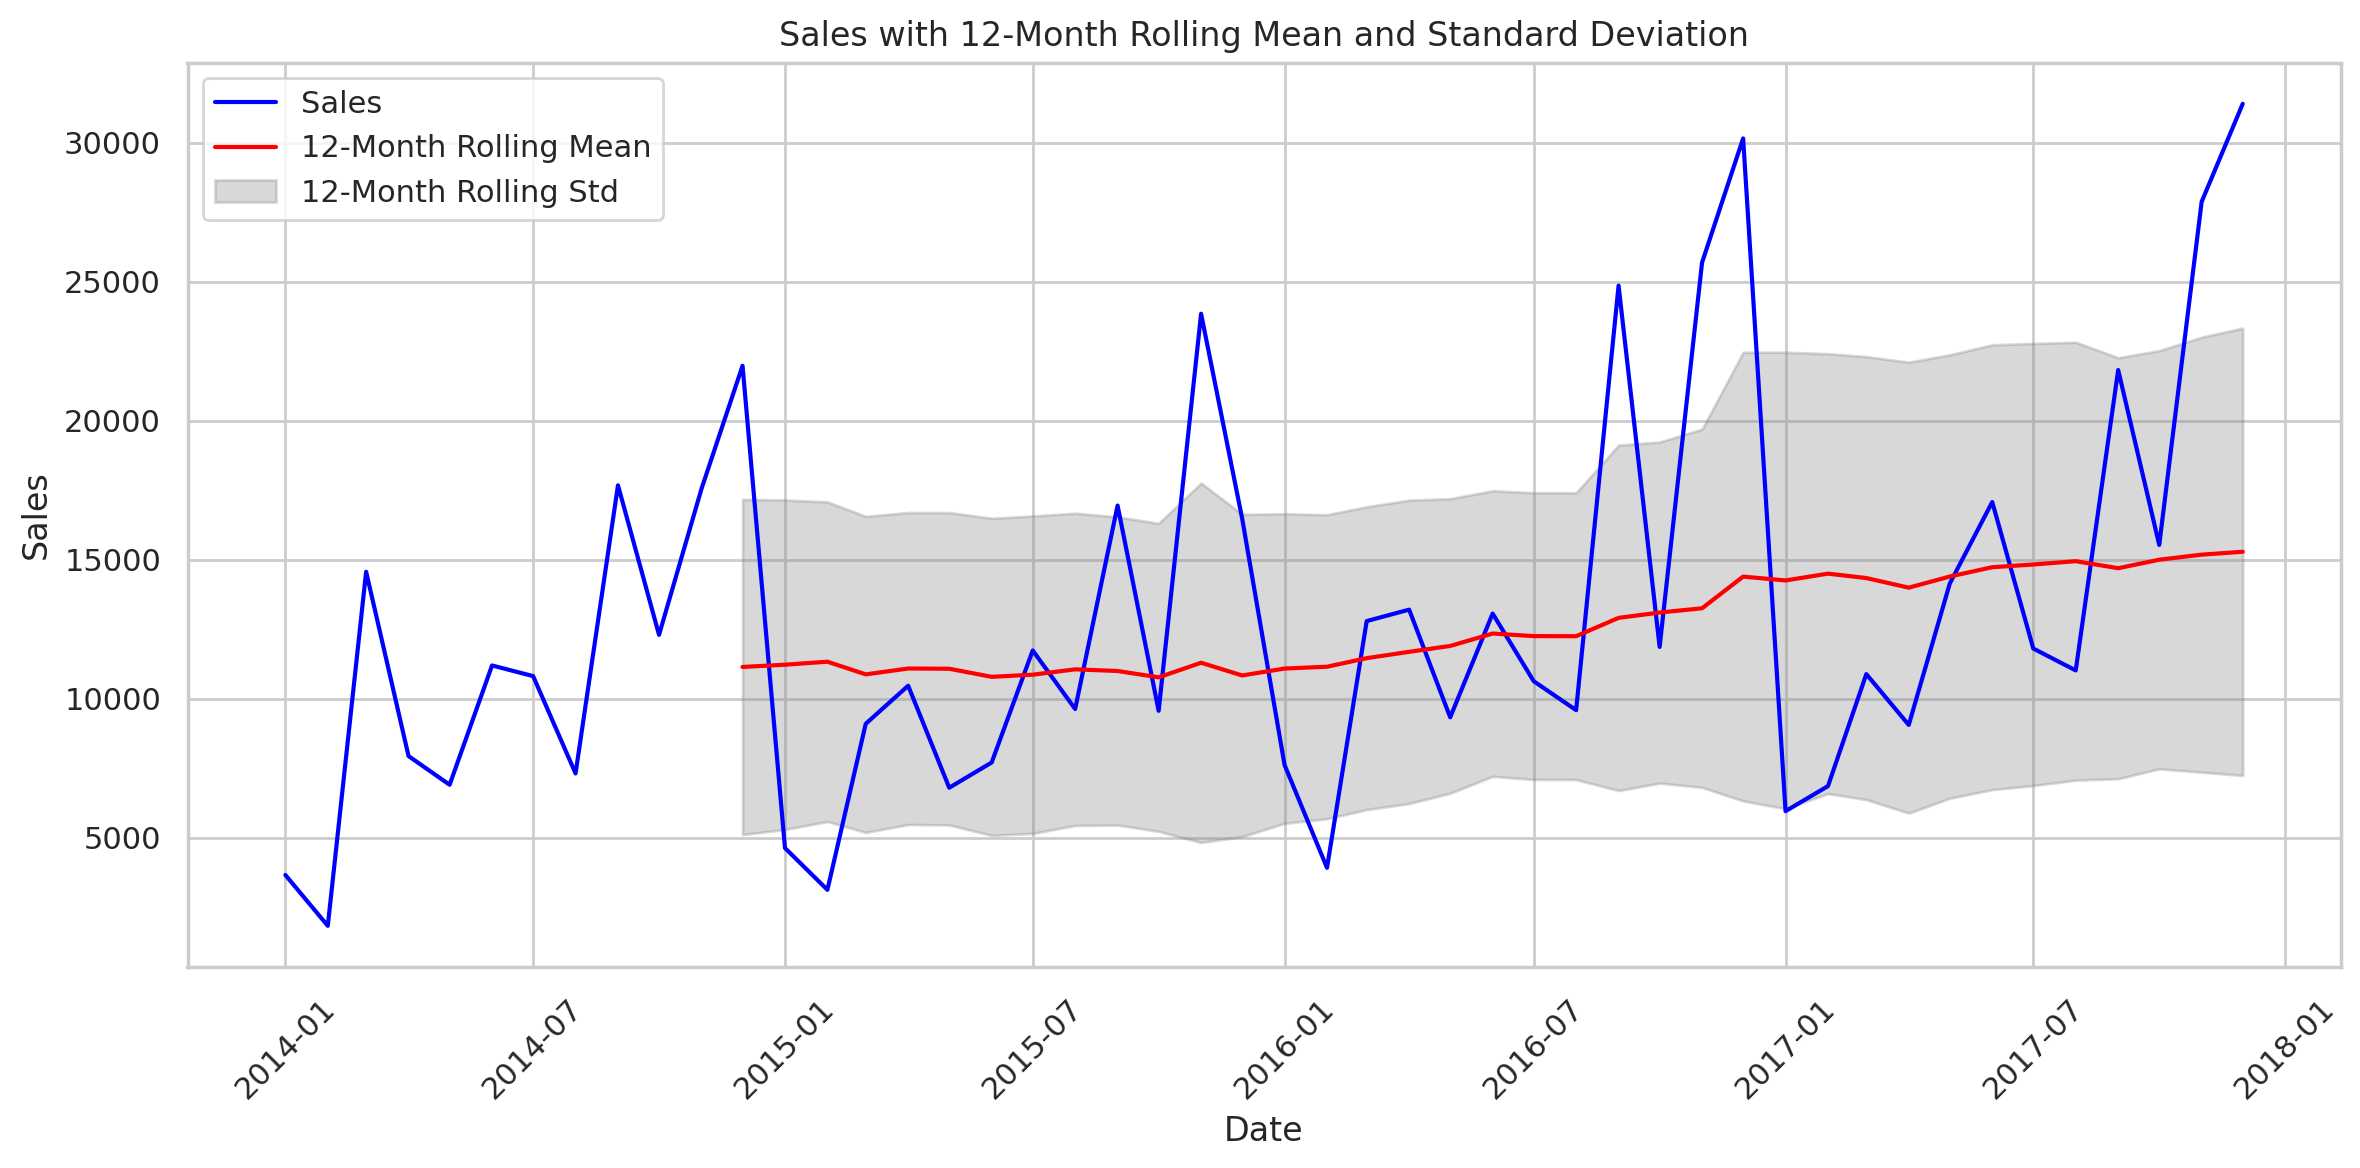

In [ ]:
# Set the rolling window size (12 months)
window_size = 12

# Calculate the rolling mean and standard deviation for 'Sales' (or replace with another column)
mdf['Rolling_Mean'] = mdf['Sales'].rolling(window=window_size).mean()
mdf['Rolling_Std'] = mdf['Sales'].rolling(window=window_size).std()

# Plot the original 'Sales' data
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(data=mdf, x=mdf.index, y='Sales', label='Sales', color='blue')

# Plot the rolling mean
sns.lineplot(data=mdf, x=mdf.index, y='Rolling_Mean', label=f'{window_size}-Month Rolling Mean', color='red')

# Plot the rolling standard deviation (as a shaded area to indicate volatility)
plt.fill_between(mdf.index, mdf['Rolling_Mean'] - mdf['Rolling_Std'], mdf['Rolling_Mean'] + mdf['Rolling_Std'],
                 color='gray', alpha=0.3, label=f'{window_size}-Month Rolling Std')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f'Sales with {window_size}-Month Rolling Mean and Standard Deviation')

# Legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()


## 7.3 Decomposition (Separating Trend, Seasonality, and Residuals)
<a id="decomposition"></a>

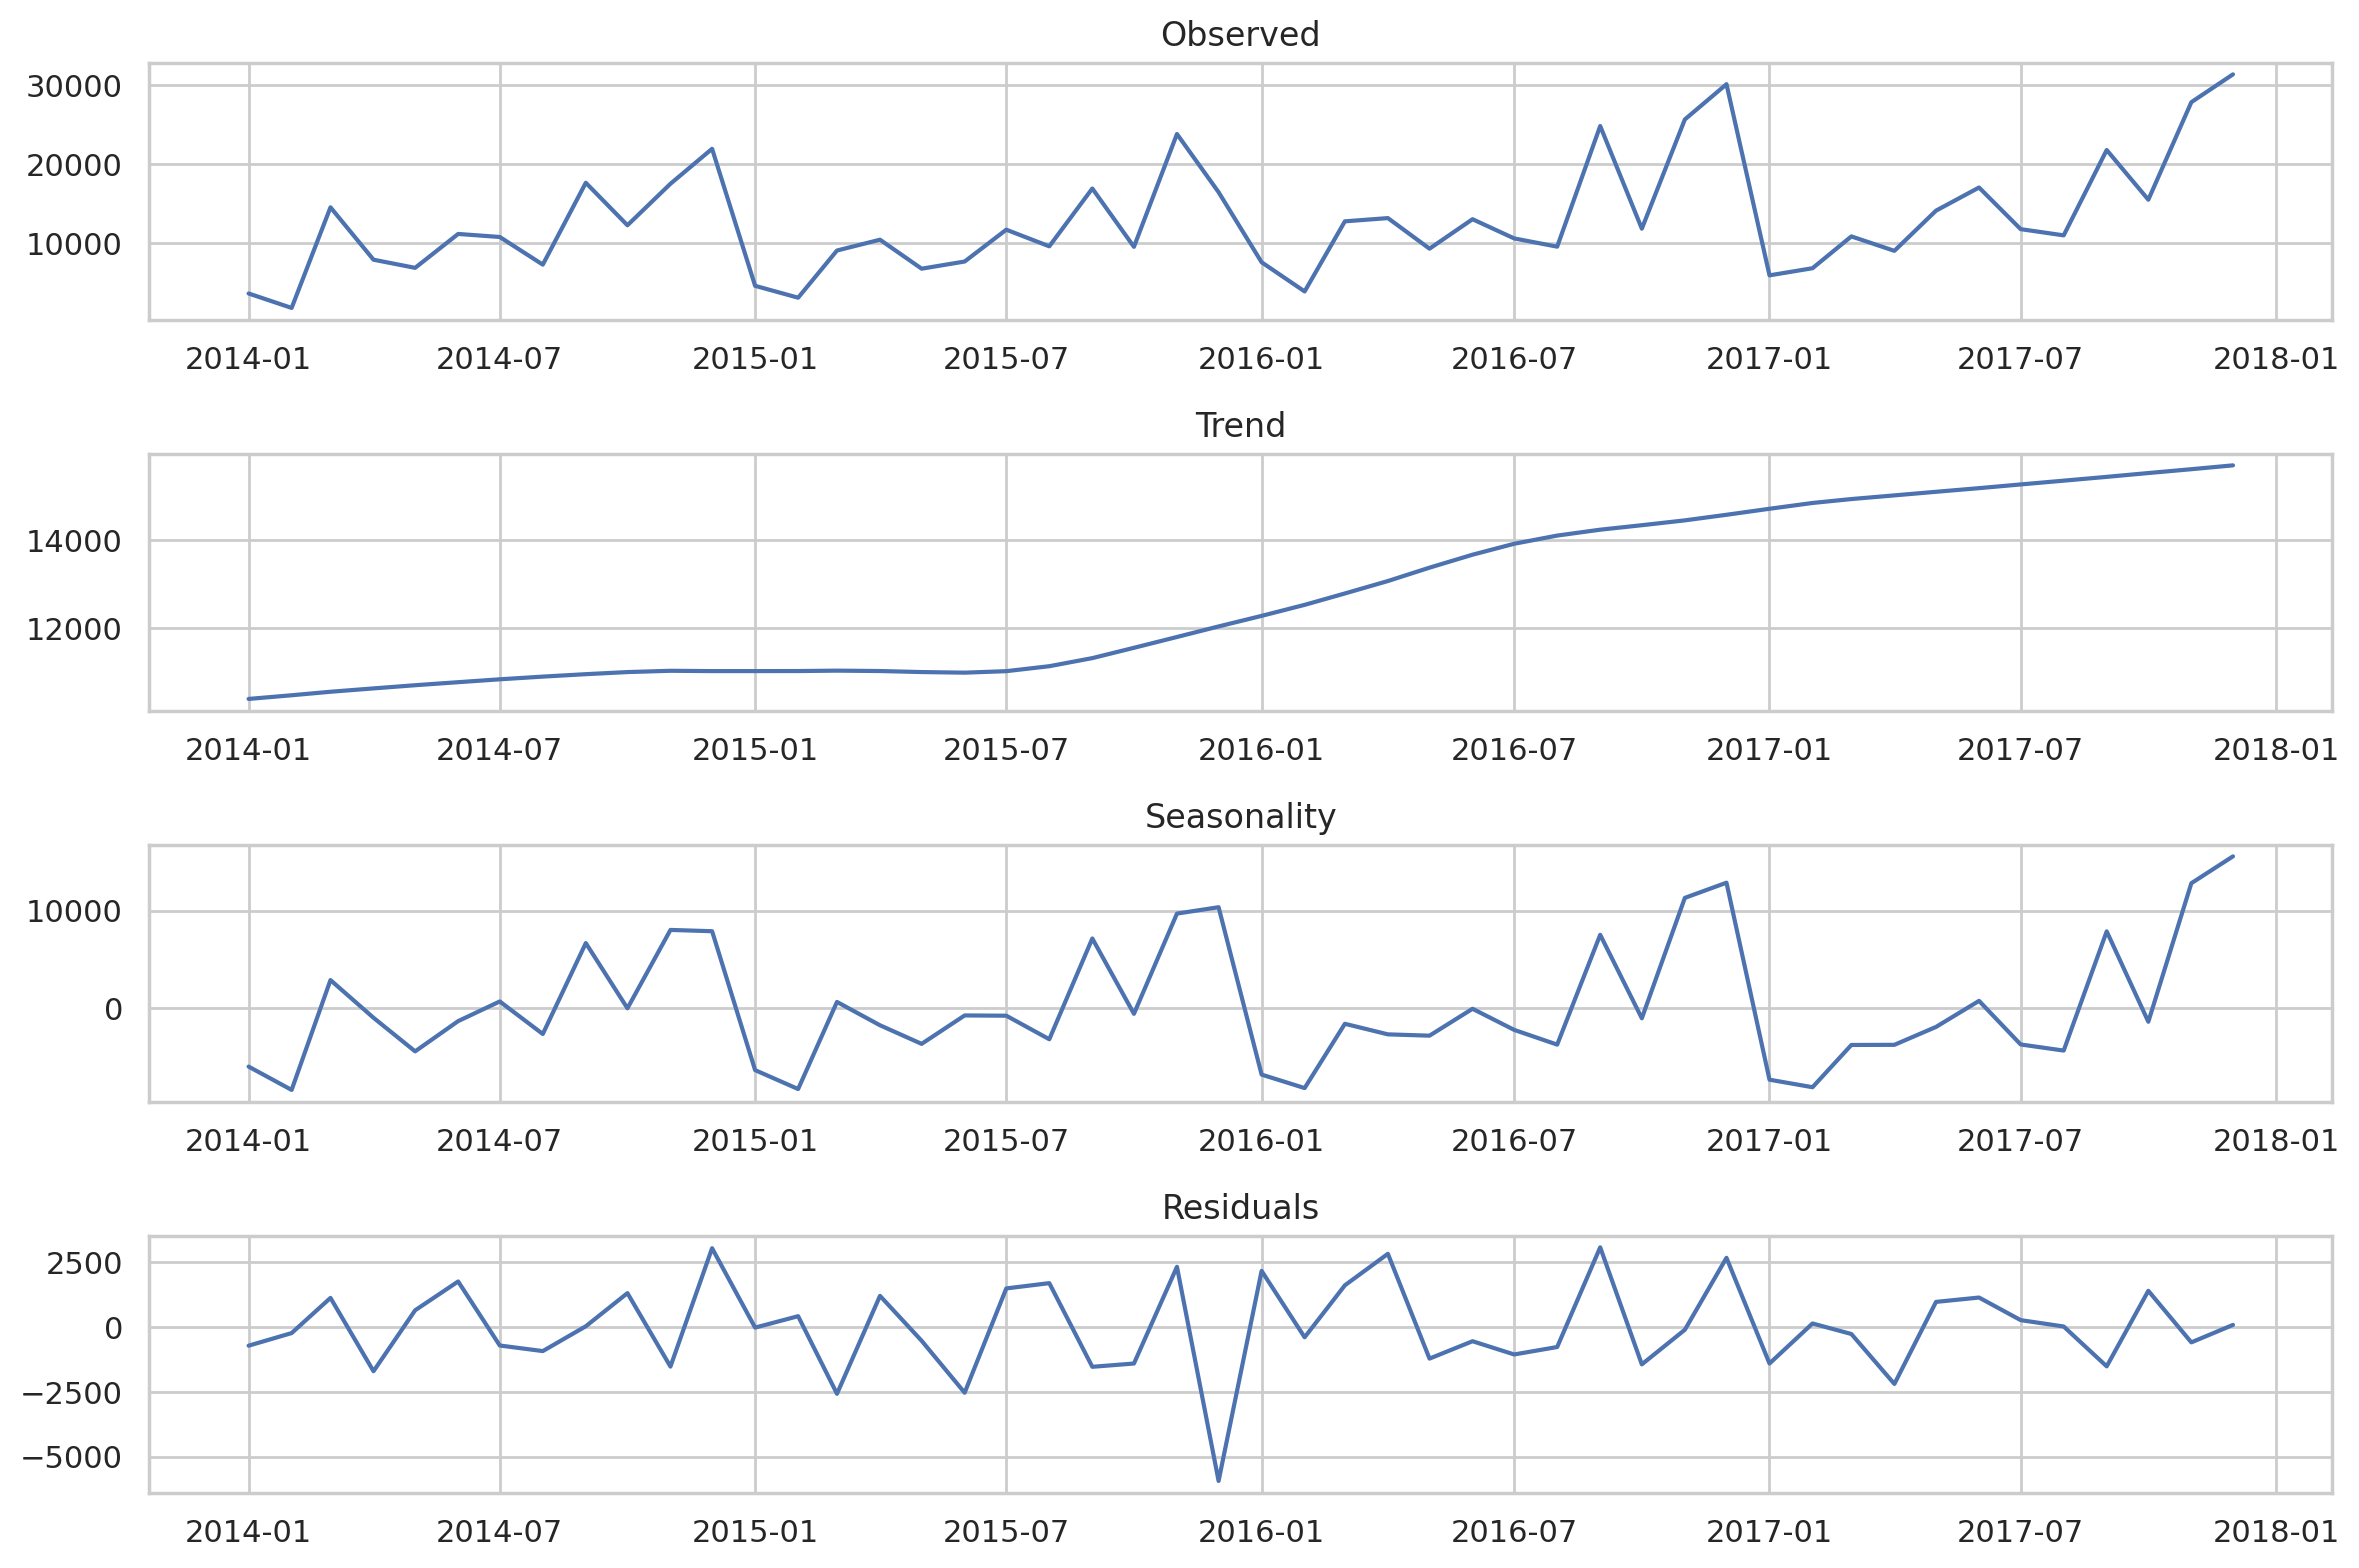

In [ ]:
# Apply STL decomposition
stl = STL(mdf['Sales'], seasonal=13)
result = stl.fit()

# Plot the decomposition
plt.figure(figsize=(12, 8), dpi=200)

plt.subplot(4, 1, 1)
plt.plot(mdf.index, result.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(mdf.index, result.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(mdf.index, result.seasonal)
plt.title('Seasonality')

plt.subplot(4, 1, 4)
plt.plot(mdf.index, result.resid)
plt.title('Residuals')

plt.tight_layout()
plt.show()

## 7.4 Seasonal Plots: Comparing Sales Across Different Time Periods

---


<a id="seasonal-plots"></a>

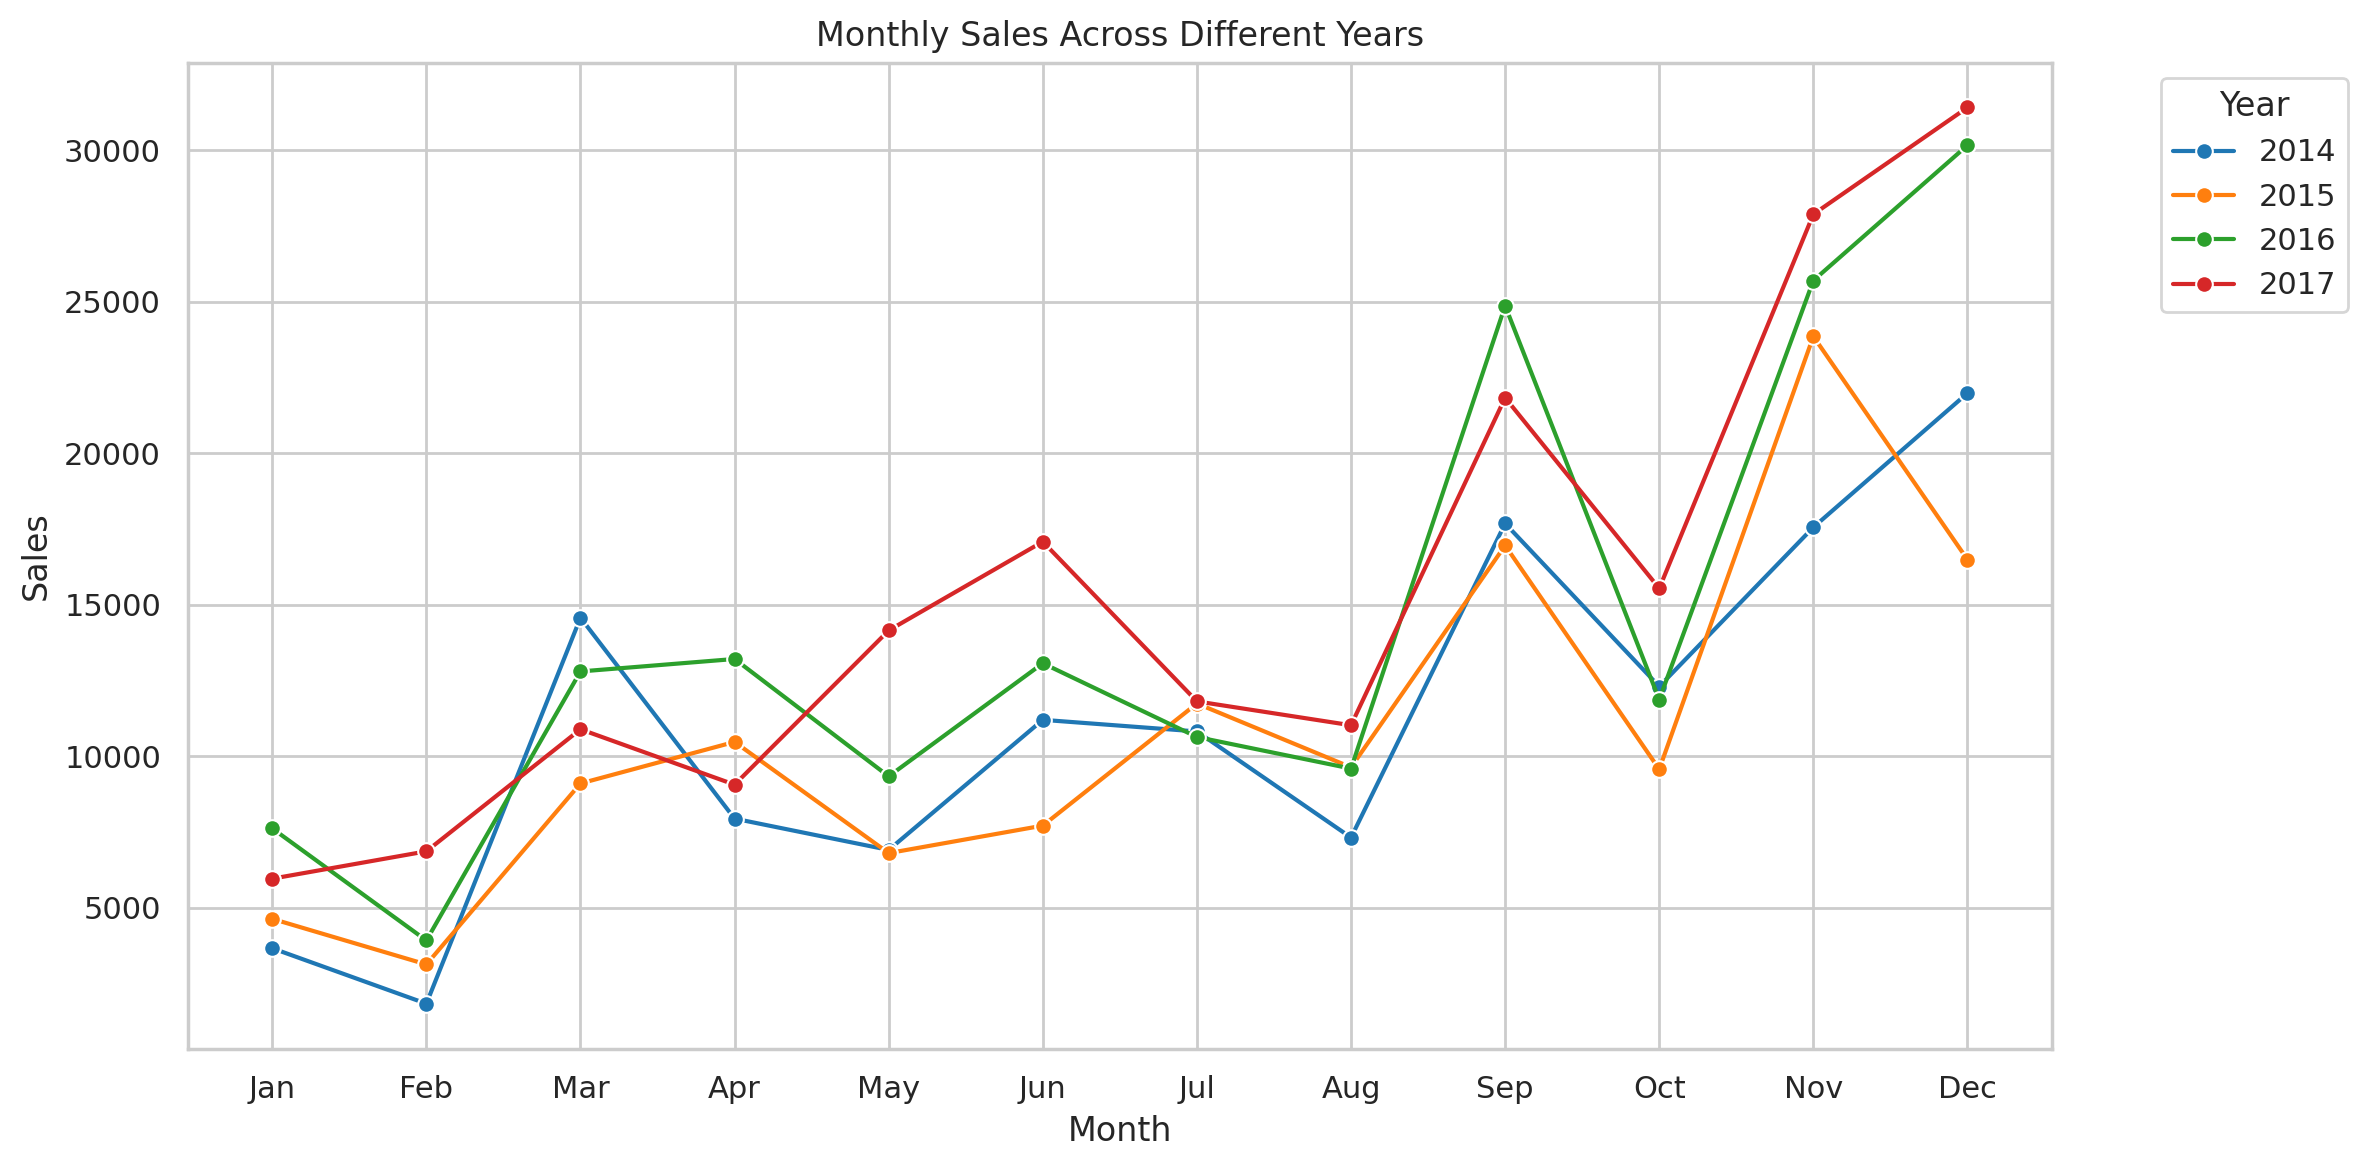

In [ ]:
# Extract the month and year from the 'Date' column
mdf['Month'] = mdf.index.month
mdf['Year'] = mdf.index.year

# Create a seasonal plot: 'Sales' (or another column) vs Month, colored by Year
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(data=mdf, x='Month', y='Sales', hue='Year', marker='o', palette='tab10')

# Customize plot
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales Across Different Years')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


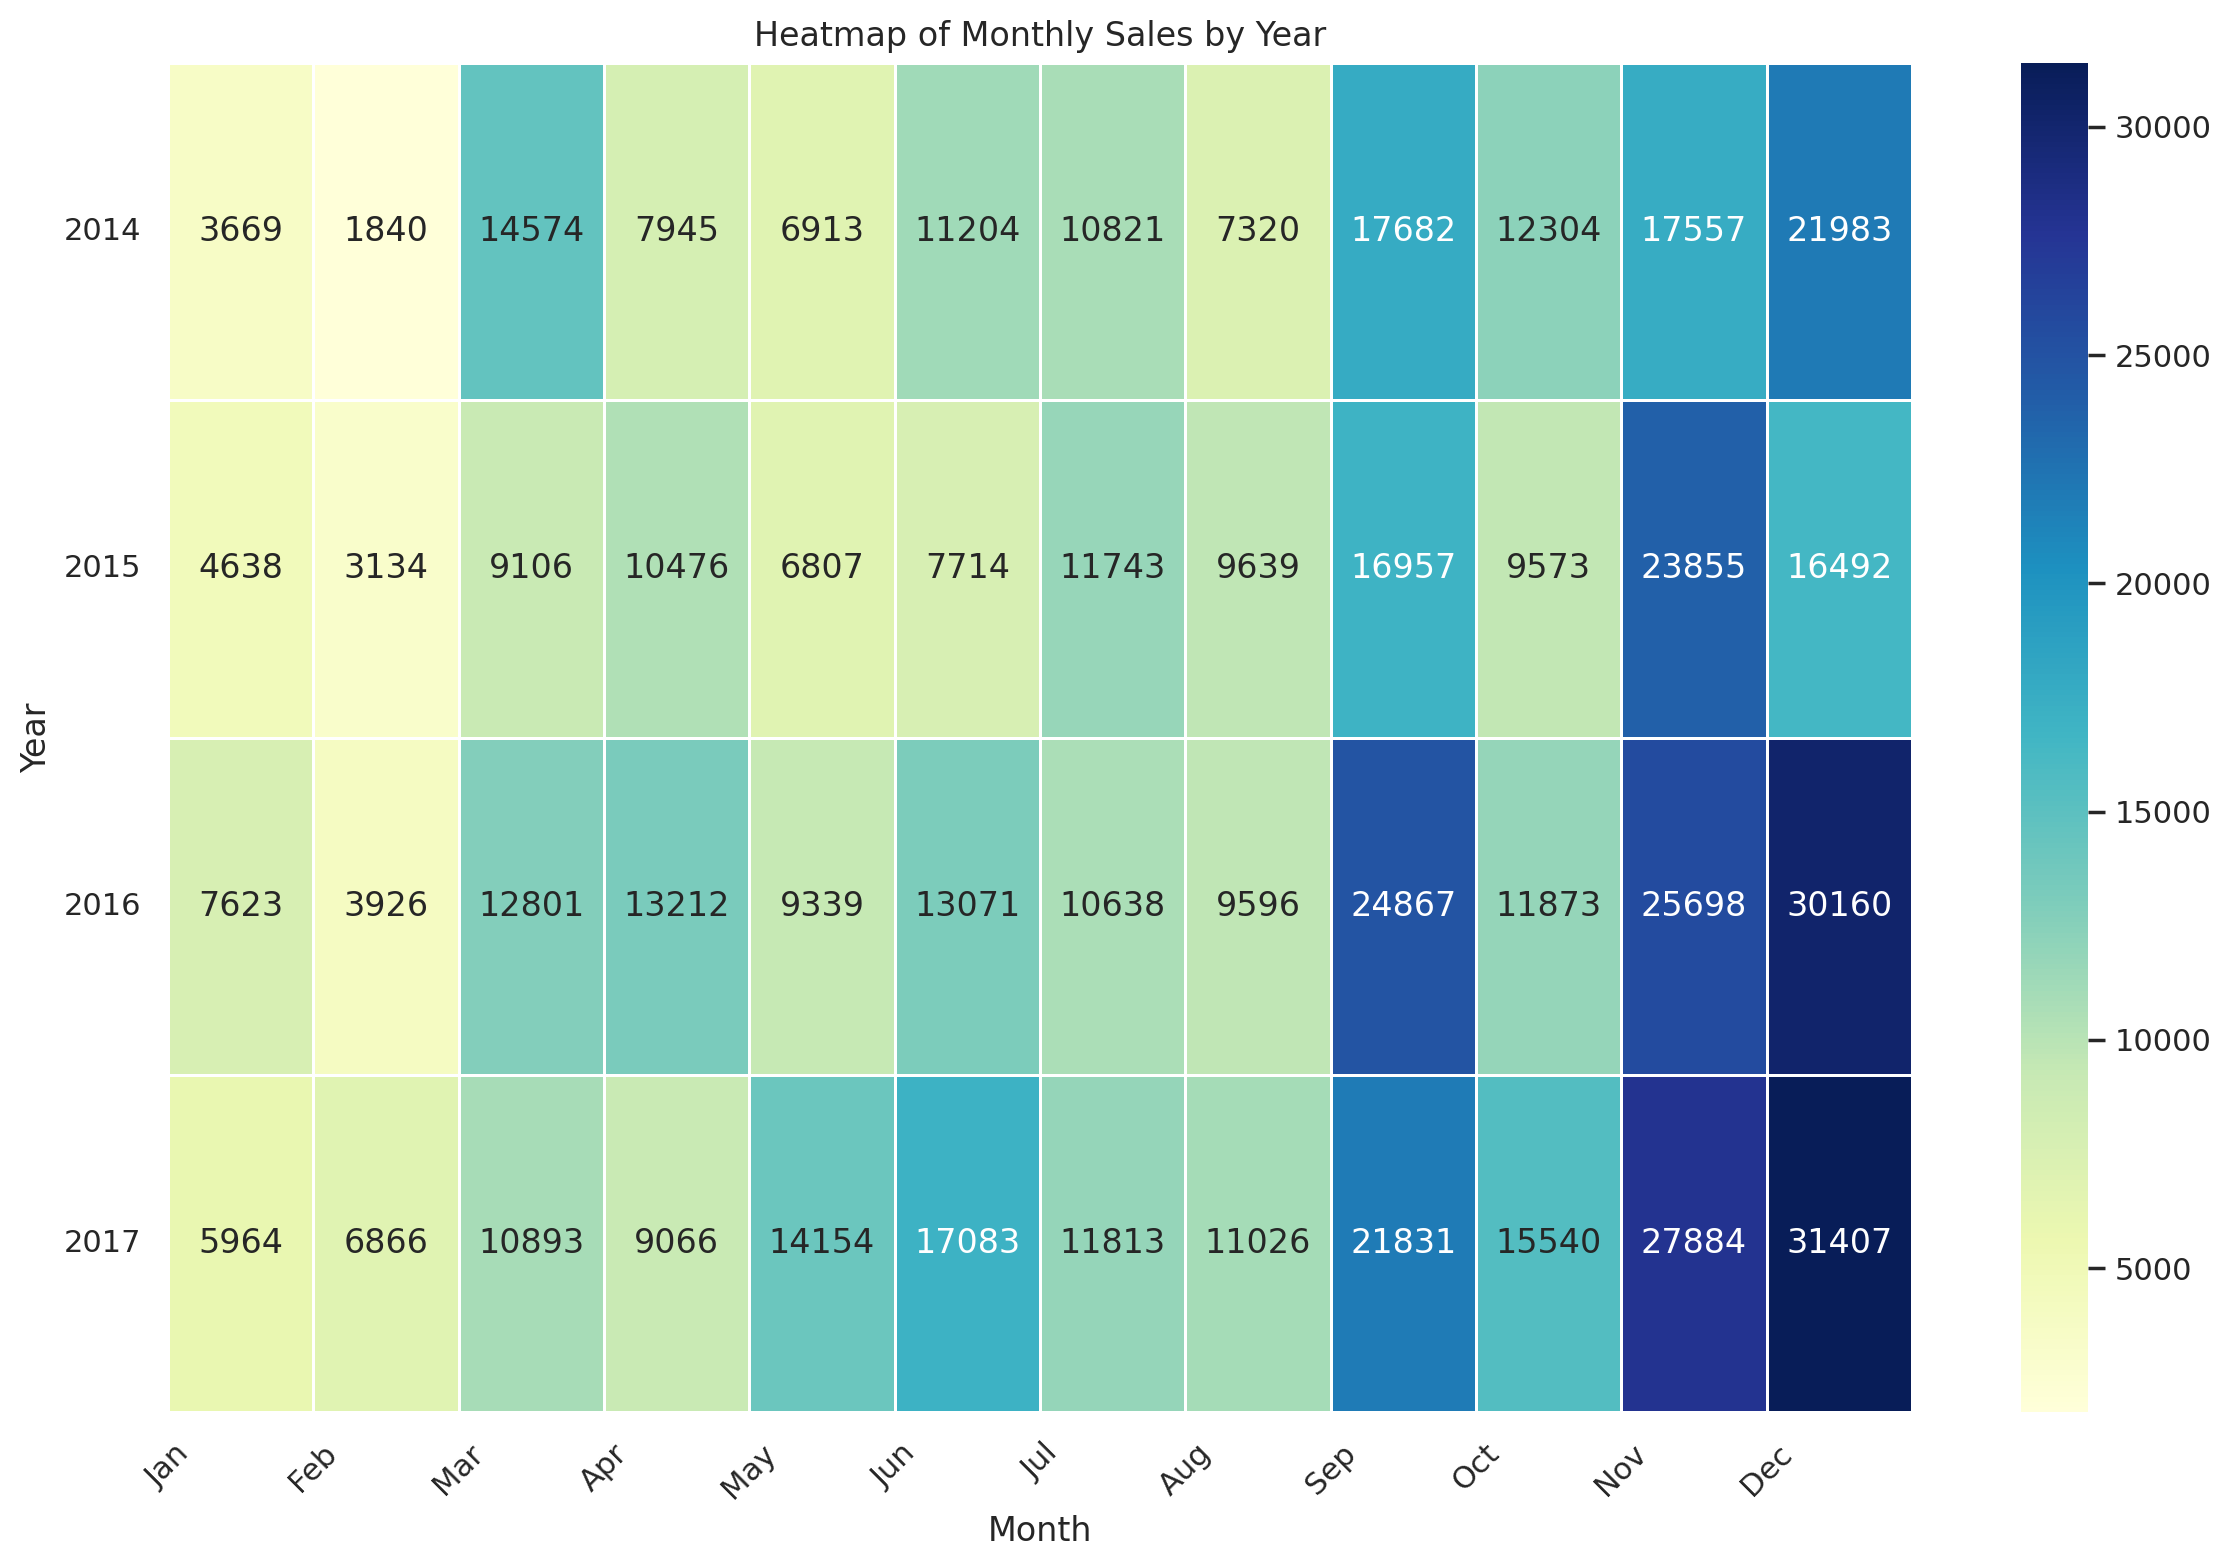

In [ ]:
# Pivot the data to create a matrix of Sales by Year and Month
heatmap_data = mdf.pivot_table(index=mdf.index.year, columns=mdf.index.month, values='Sales', aggfunc='sum')

# Create a heatmap
plt.figure(figsize=(12, 8), dpi=200)
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=.5)

# Customize plot
plt.xlabel('Month')
plt.ylabel('Year')
plt.title('Heatmap of Monthly Sales by Year')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 7.5 Stationarity Check
<a id="stationarity-check"></a>

### Time Series Stationarity Check Workflow

1. **Visual Inspection**: Begin by plotting the time series to observe any trends, seasonality, or changes in variance over time. This step provides an initial understanding of whether the data might be non-stationary.
  
2. **Dickey-Fuller Test**: Conduct the Augmented Dickey-Fuller (ADF) test to statistically assess stationarity. The null hypothesis of this test is that the time series is non-stationary. If the p-value is ≤ 0.05, the null hypothesis is rejected, indicating that the series is stationary.

3. **Actions Based on ADF Results**:
   - **If Stationary (p-value ≤ 0.05)**: Proceed with time series modeling (e.g., ARIMA, SARIMA), and consider checking autocorrelation with ACF and PACF plots.
   - **If Non-Stationary (p-value > 0.05)**: Apply differencing to transform the series into a stationary one. If necessary, use additional techniques like log transformation or seasonal differencing. After transformations, re-run the Dickey-Fuller test to confirm stationarity before proceeding with modeling.

Time Series Plot: Visual Inspection


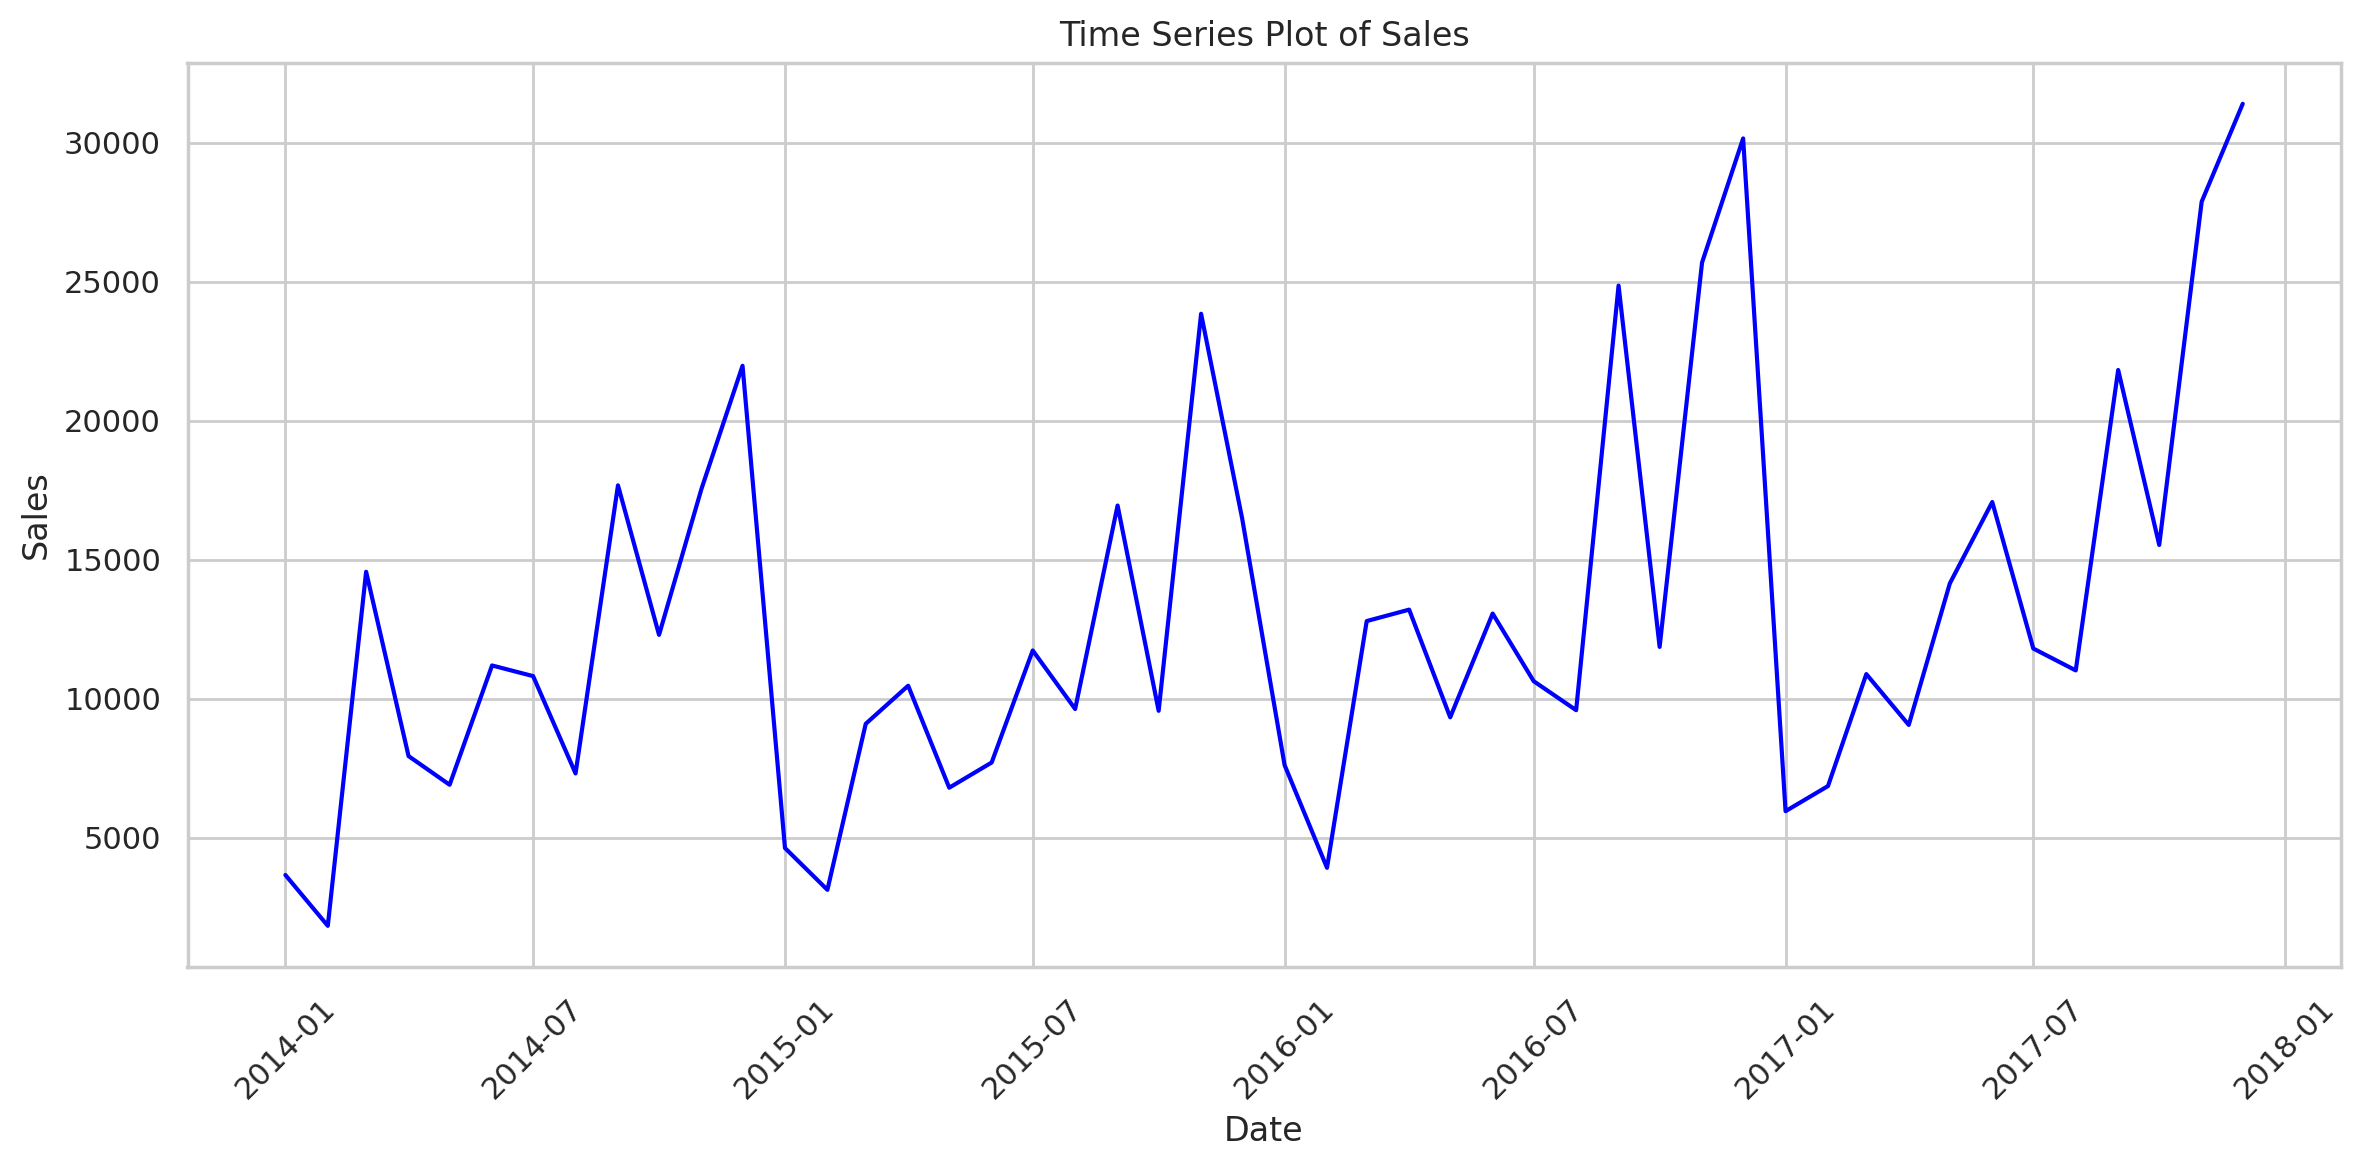

In [ ]:
print("Time Series Plot: Visual Inspection")

# Plot the time series data
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(data=mdf, x=mdf.index, y='Sales', color='blue')

# Customize plot
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Time Series Plot of Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
print("Statistical Tests: Dickey-Fuller Test")

# Perform the Dickey-Fuller test
adf_result = adfuller(mdf['Sales'])

# Extract and display the test statistic and p-value
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Conclusion based on p-value
if adf_result[1] <= 0.05:
    print("Reject the null hypothesis - The time series is stationary.")
else:
    print("Fail to reject the null hypothesis - The time series is non-stationary.")

Statistical Tests: Dickey-Fuller Test
ADF Statistic: -4.420240168034889
p-value: 0.00027328437369477526
Reject the null hypothesis - The time series is stationary.


## 7.6 Autocorrelation and Partial Autocorrelation
<a id="autocorrelation"></a>

1. **Autocorrelation Function (ACF) Plot**:
   - **Definition**: The ACF plot shows the correlation of a time series with its own past values (lags). It measures how the current value of the series is related to its past values at various lags.
   - **Purpose**: Helps identify the presence of patterns, periodicity, or seasonality in the data. It is useful for determining the order of the MA (Moving Average) component in time series models.

2. **Partial Autocorrelation Function (PACF) Plot**:
   - **Definition**: The PACF plot shows the correlation of a time series with its past values after removing the effects of intermediate lags. It measures the direct relationship between the current value and past values, excluding the influence of intermediate lags.
   - **Purpose**: Helps identify the direct effect of past values on the current value, useful for determining the order of the AR (Auto-Regressive) component in time series models.

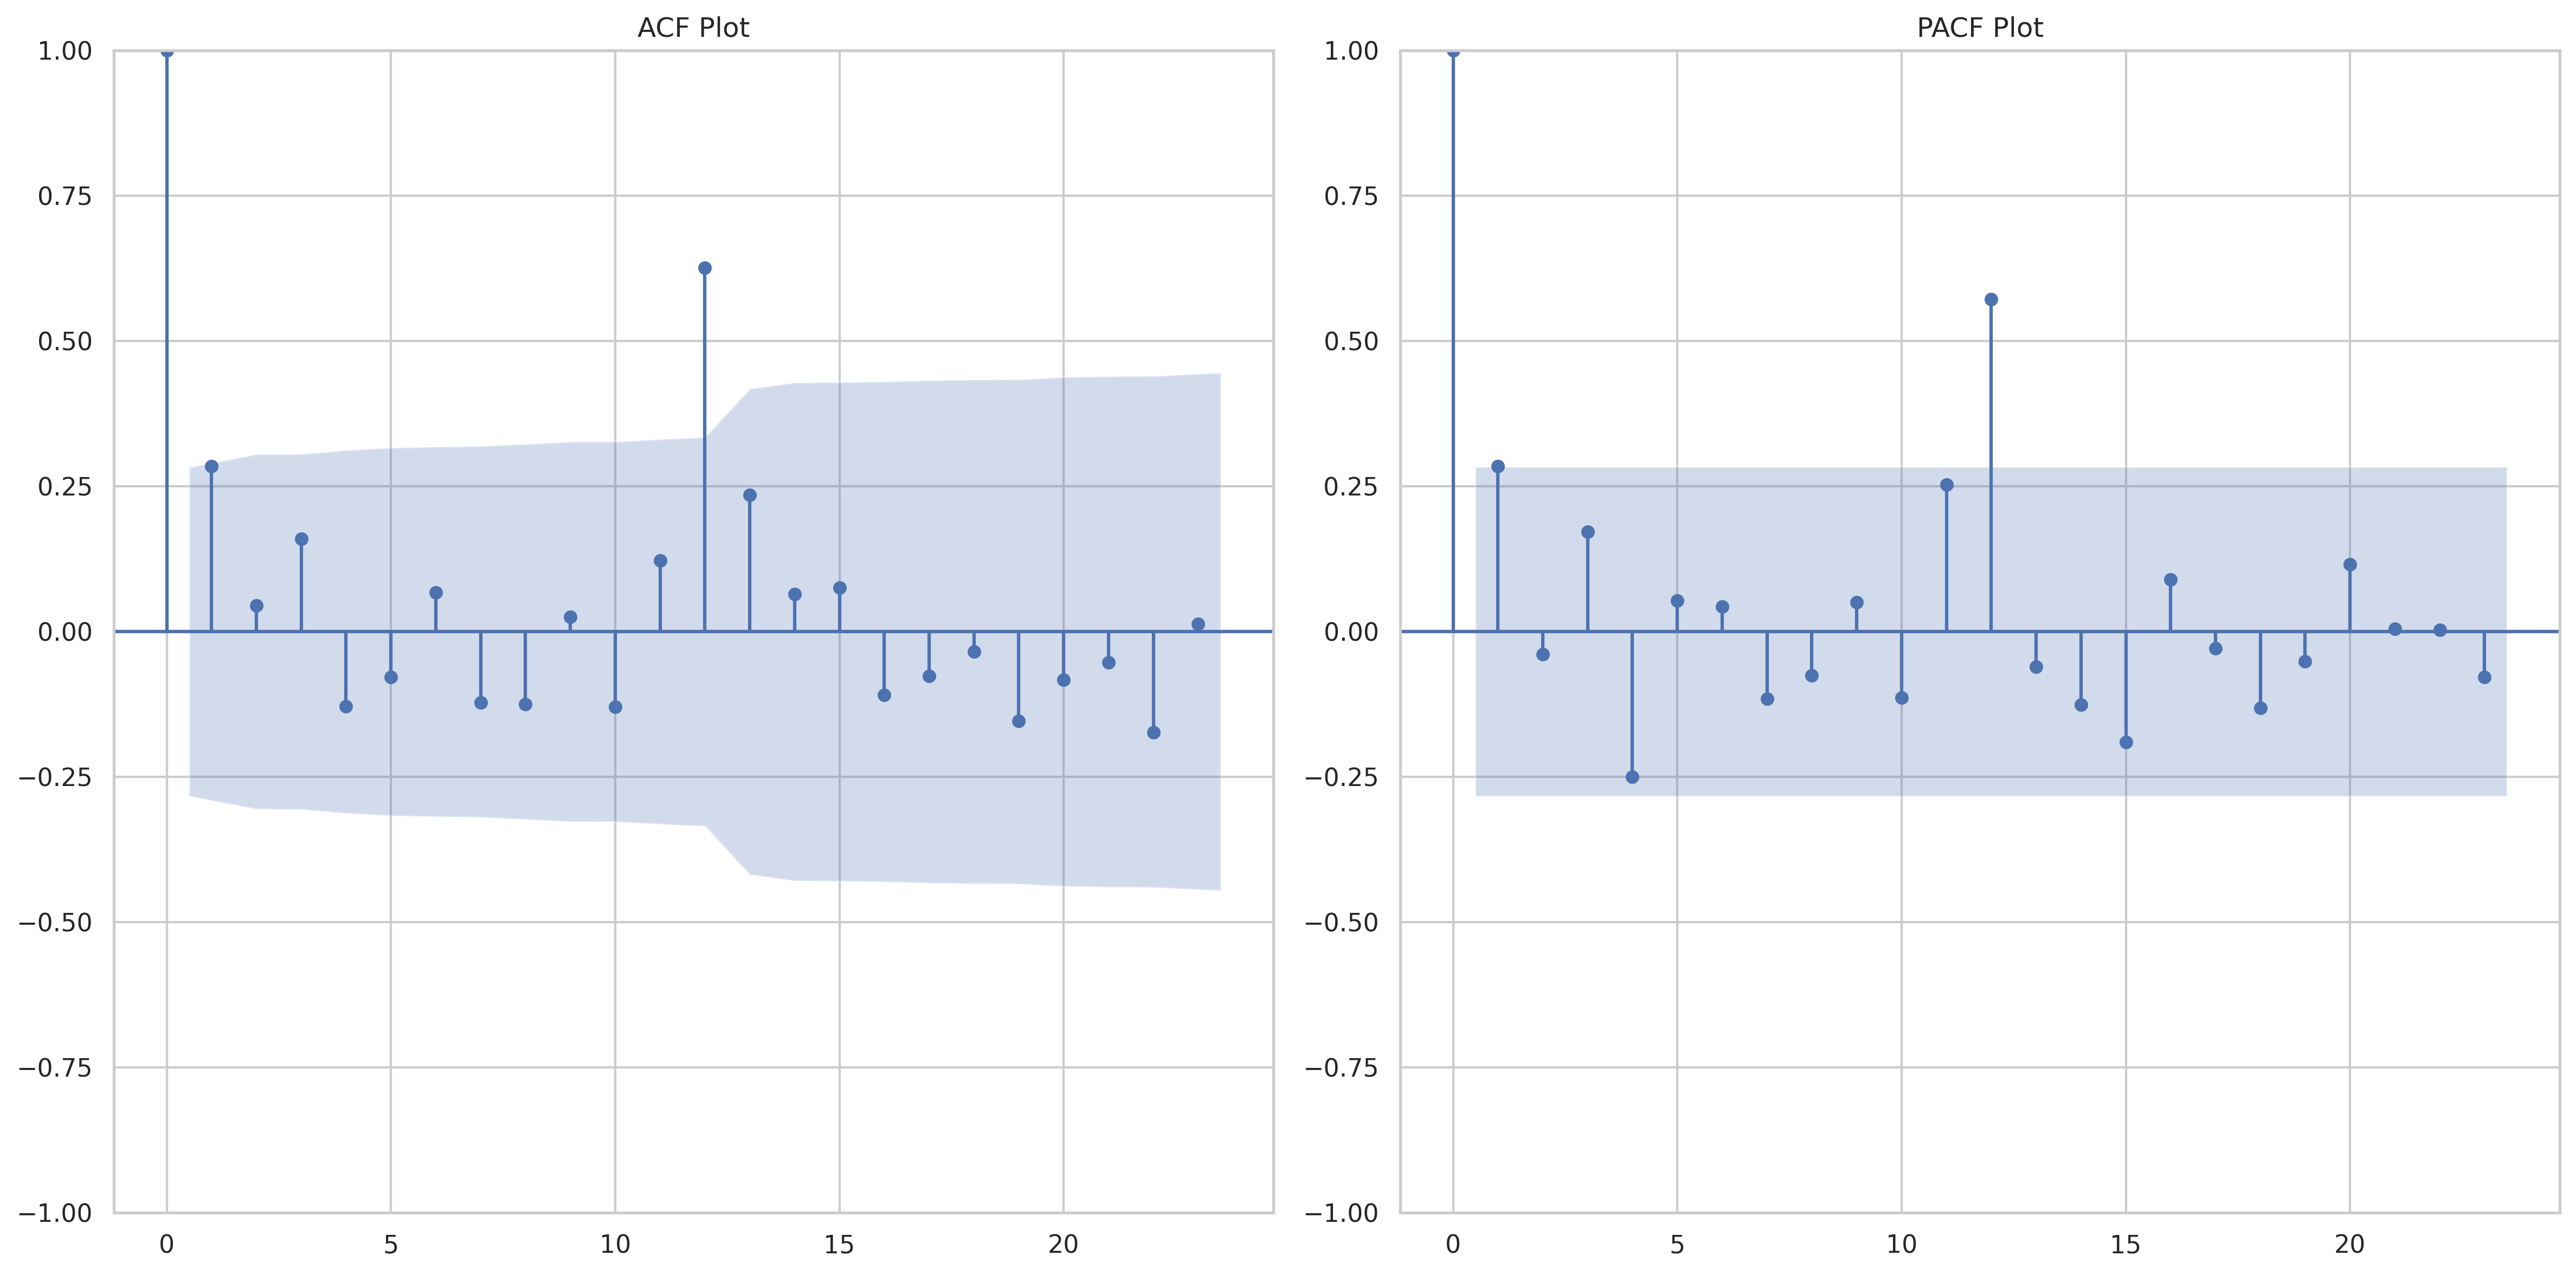

In [ ]:
# Determine the maximum number of lags
max_lags = len(mdf) // 2 - 1

# Set the size and resolution of the plot
plt.figure(figsize=(16, 8), dpi=300)

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(mdf['Sales'], ax=plt.gca(), lags=max_lags)
plt.title('ACF Plot')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(mdf['Sales'], ax=plt.gca(), lags=max_lags)
plt.title('PACF Plot')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### Determining AR and MA Orders from ACF and PACF

1. **Auto-Regressive (AR) Order**:
   - **PACF Analysis**: The AR order is typically the lag number at which the PACF values drop to near-zero. For the provided PACF values, the AR order could be around 12, where the PACF values start stabilizing.

2. **Moving Average (MA) Order**:
   - **ACF Analysis**: The MA order is typically the lag number at which the ACF values drop to near-zero. For the provided ACF values, the MA order could be around 12, where the ACF values start stabilizing.

## 7.7 Feature Impacts
<a id="feature-impacts"></a>

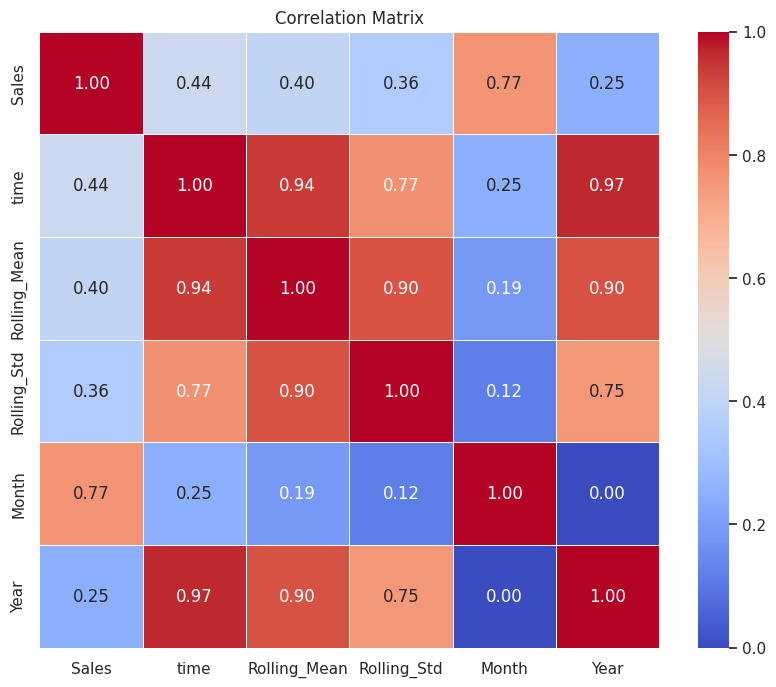

In [ ]:
correlation_matrix = mdf.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# 8. Modelling
<a id="modelling"></a>

In [ ]:
mdf.shape

(48, 6)

In [ ]:
# Set pandas to display floating point numbers in a readable format
pd.set_option('display.float_format', '{:,.2f}'.format)

# Now, check the DataFrame to see if the numbers are formatted correctly
mdf.head()


Sales  time  Rolling_Mean  Rolling_Std  Month  Year
month                                                             
2014-01-01  3,668.70     0           NaN          NaN      1  2014
2014-02-01  1,839.66     1           NaN          NaN      2  2014
2014-03-01 14,573.96     2           NaN          NaN      3  2014
2014-04-01  7,944.84     3           NaN          NaN      4  2014
2014-05-01  6,912.79     4           NaN          NaN      5  2014

In [ ]:
mdf.tail()

Sales  time  Rolling_Mean  Rolling_Std  Month  Year
month                                                             
2017-08-01 11,025.70    43     14,955.20     7,875.61      8  2017
2017-09-01 21,831.40    44     14,702.26     7,571.21      9  2017
2017-10-01 15,539.79    45     15,007.86     7,520.45     10  2017
2017-11-01 27,884.21    46     15,190.05     7,823.34     11  2017
2017-12-01 31,407.47    47     15,293.98     8,045.43     12  2017

In [ ]:
forecast_steps = 12

In [ ]:
train_mdf = mdf.iloc[:48 - forecast_steps]
test_mdf = mdf.iloc[48 - forecast_steps:forecast_steps + 48]

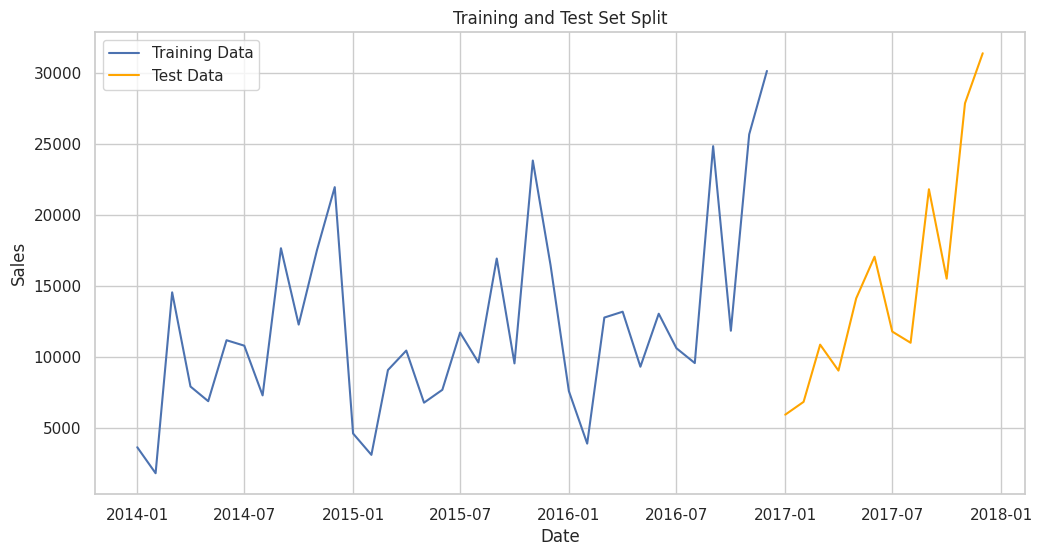

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_mdf.index, train_mdf['Sales'], label='Training Data')
plt.plot(test_mdf.index, test_mdf['Sales'], label='Test Data', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Training and Test Set Split')
plt.legend()
plt.show()

## 8.1 ARIMA
<a id="arima"></a>

In [ ]:
p, d, q = forecast_steps, 0, forecast_steps
arma_model = ARIMA(train_mdf['Sales'], order=(p, d, q))
arma_results = arma_model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
forecast = arma_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
forecast_index = pd.date_range(start=train_mdf.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='M')
forecast_mean.index = pd.to_datetime(forecast_mean.index)
forecast_df = forecast_mean.to_frame(name='Forecast')

<ipython-input-94-7842f3b2f8b7>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_mdf.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='M')


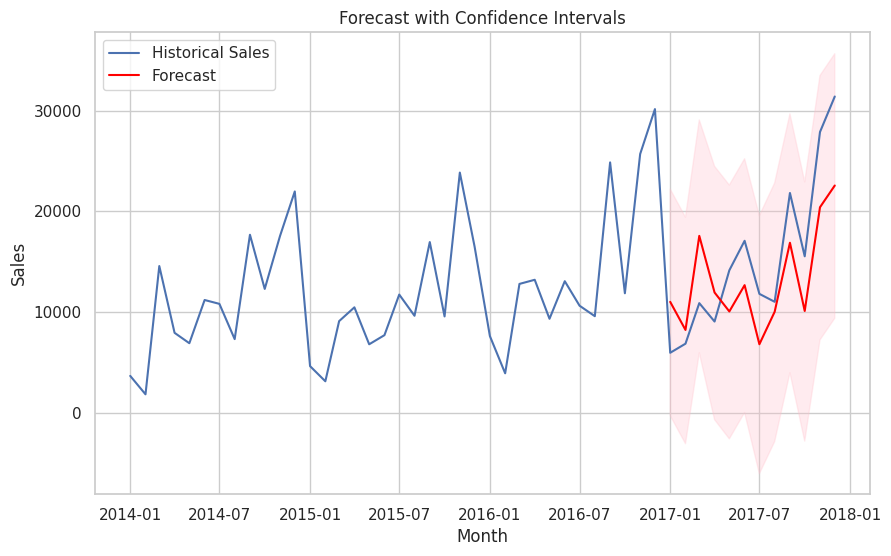

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mdf.index, mdf['Sales'], label='Historical Sales')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Forecast with Confidence Intervals')
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(test_mdf['Sales'], forecast_df['Forecast'][:len(test_mdf)])
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 4762.025360218992


In [ ]:
mse = mean_squared_error(test_mdf['Sales'], forecast_df['Forecast'][:len(test_mdf)])
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 27519979.651725173


In [ ]:
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 5245.94888001448


In [ ]:
r2 = r2_score(test_mdf['Sales'], forecast_df['Forecast'])
print(f"R-square (R2): {r2}")

R-square (R2): 0.53619176609135


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error



# Data Cleaning: Remove Outliers & Drop Unnecessary Columns
data = df.copy()  # Avoid modifying the original DataFrame
data = data[data["Sales"] > 0]  # Assuming Sales should be > 0
data.drop(columns=["Unnecessary_Column"], axis=1, errors="ignore", inplace=True)  # Drop unnecessary columns safely

# Train-Test Split
train_size = int(len(data) * 0.8)
train_df, test_df = data[:train_size], data[train_size:]  # Using 'data' instead of 'df'

# Fit ARIMA Model
p, d, q = 3, 1, 2  # Example values, tune as needed

try:
    arima_model = ARIMA(train_df["Sales"], order=(p, d, q)).fit()

    # Save the trained model
    with open("arima_model.pkl", "wb") as f:
        pickle.dump(arima_model, f)

    print("Model saved successfully.")

except Exception as e:
    print(f"Error training ARIMA model: {e}")


Model saved successfully.


In [ ]:
from google.colab import files
files.download("arima_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 8.2 SARIMA
<a id="sarima"></a>

In [ ]:
p, d, q = 1, 1, 1
P, D, Q, S = 1, 1, 1, 12

sarima_model = SARIMAX(train_mdf['Sales'],
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, S))
sarima_results = sarima_model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
forecast_steps = forecast_steps
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [ ]:
forecast_index = pd.date_range(start=train_mdf.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='M')
forecast_mean.index = pd.to_datetime(forecast_mean.index)
forecast_df = forecast_mean.to_frame(name='Forecast')

<ipython-input-105-b5d2941db41c>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_mdf.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='M')


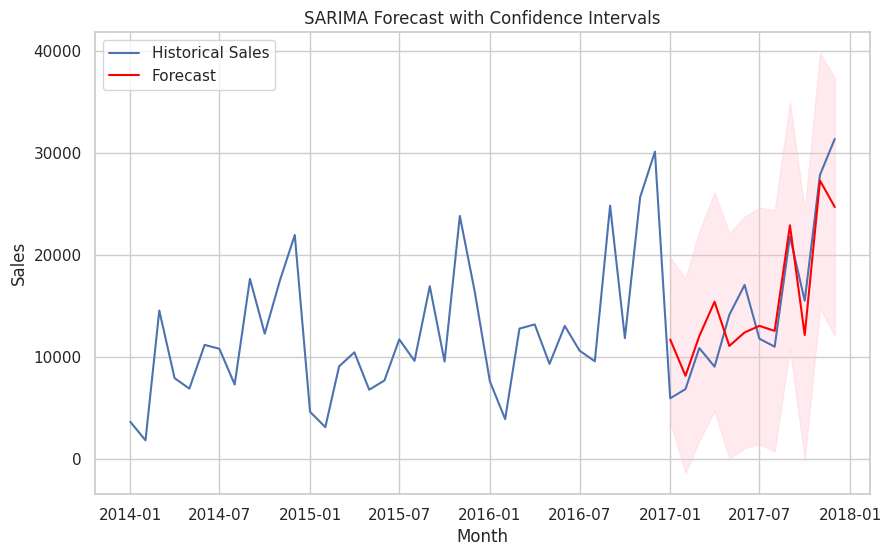

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mdf.index, mdf['Sales'], label='Historical Sales')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('SARIMA Forecast with Confidence Intervals')
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(test_mdf['Sales'], forecast_df['Forecast'])
print(f"Mean Absolute Error (MAE): {mae}")

mse = mean_squared_error(test_mdf['Sales'], forecast_df['Forecast'])
print(f"Mean Squared Error (MSE): {mse}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")
r2 = r2_score(test_mdf['Sales'], forecast_df['Forecast'])
print(f"R-square (R2): {r2}")

Mean Absolute Error (MAE): 3070.7981118991606
Mean Squared Error (MSE): 14112789.556631723
Root Mean Squared Error (RMSE): 3756.6992901524236
R-square (R2): 0.762149969490422


## 8.3 FB Prophet
<a id="fb-prophet"></a>

In [ ]:
df_prophet = mdf.reset_index()

In [ ]:
df_prophet = df_prophet[["month", "Sales"]]

In [ ]:
df_prophet.columns = ['ds', 'y']

In [ ]:
train_prophet = df_prophet.iloc[:48 - forecast_steps]
test_prophet = df_prophet.iloc[48 - forecast_steps:forecast_steps + 48]

In [ ]:
model = Prophet()
model.fit(train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fmefooo/ya47_sib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1fmefooo/6849p65v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96573', 'data', 'file=/tmp/tmp1fmefooo/ya47_sib.json', 'init=/tmp/tmp1fmefooo/6849p65v.json', 'output', 'file=/tmp/tmp1fmefooo/prophet_modela0b545_t/prophet_model-20250205060833.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:08:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:08:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = test_prophet[['ds']]

In [ ]:
forecast = model.predict(future)

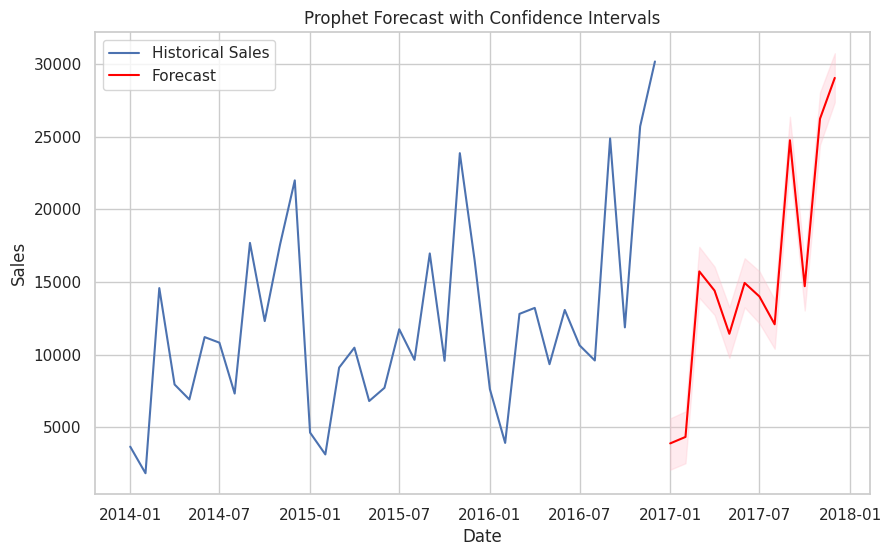

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Historical Sales')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Prophet Forecast with Confidence Intervals')
plt.legend()
plt.show()

In [ ]:
actual = test_prophet['y'].values
forecasted = forecast['yhat'].values

In [ ]:
mae = mean_absolute_error(actual, forecasted)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 2555.8493160133253


In [ ]:
mse = mean_squared_error(actual, forecasted)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 8167555.278571416


In [ ]:
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 2857.893503714128


In [ ]:
r2 = r2_score(actual, forecasted)
r2

0.8623480308835183

In [ ]:
import pandas as pd

# Assuming 'mdf' contains 'Month' column
# Create a 'Date' column by assuming the year is a fixed value (e.g., 2021)
mdf['Date'] = pd.to_datetime(mdf['Year'].astype(str) + '-' + mdf['Month'].astype(str) + '-01')

# Extract Year and Month
mdf['Year'] = mdf['Date'].dt.year
mdf['Month'] = mdf['Date'].dt.month

# Check the DataFrame
print(mdf.head())


               Sales  time  Rolling_Mean  Rolling_Std  Month  Year       Date
month                                                                        
2014-01-01  3,668.70     0           NaN          NaN      1  2014 2014-01-01
2014-02-01  1,839.66     1           NaN          NaN      2  2014 2014-02-01
2014-03-01 14,573.96     2           NaN          NaN      3  2014 2014-03-01
2014-04-01  7,944.84     3           NaN          NaN      4  2014 2014-04-01
2014-05-01  6,912.79     4           NaN          NaN      5  2014 2014-05-01


Baseline Model - MAE: 6143.895995263158, MSE: 79684833.91822189, RMSE: 8926.636203980865
XGBoost Model - MAE: 2966.2243828125, MSE: 12437260.08718496, RMSE: 3526.649980815357, R²: 0.7619261140052537
Improvement over Baseline - MAE Difference: 3177.6716124506574
Improvement over Baseline - MSE Difference: 67247573.83103693
Improvement over Baseline - RMSE Difference: 5399.986223165508
Improvement over Baseline - R² Difference: -1.2872522656472998


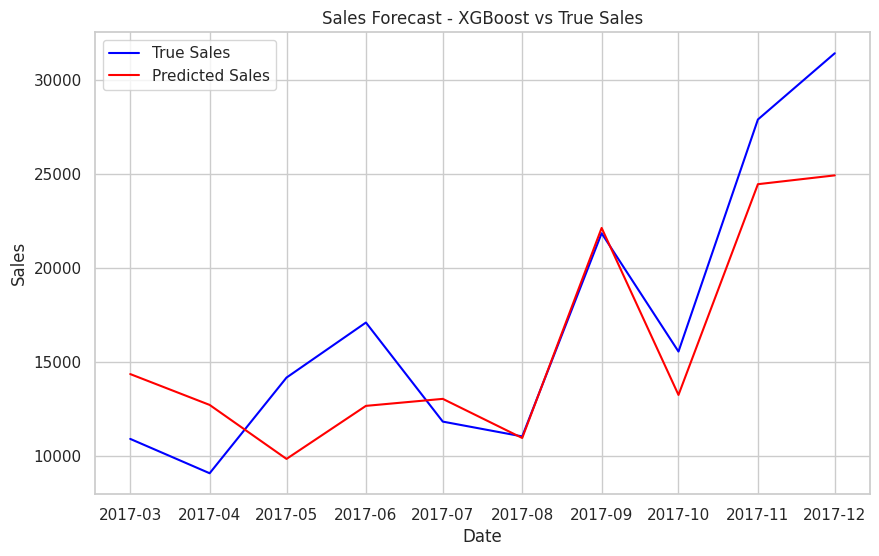

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load and preprocess the data (assuming mdf is the dataset)
# Assuming the dataset 'mdf' has columns: 'Month', 'Sales', 'Rolling_Mean', 'Rolling_Std'

df = mdf.copy()

# Prepare the data for training
X = df[[ 'Month', 'Year']]  # Features
y = df['Sales']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Baseline model (Mean model)
baseline_pred = np.mean(y_train)  # Predict the mean of training sales for the test set
baseline_mae = mean_absolute_error(y_test, [baseline_pred] * len(y_test))
baseline_mse = mean_squared_error(y_test, [baseline_pred] * len(y_test))
baseline_rmse = np.sqrt(baseline_mse)
# Calculate baseline R² (as a pseudo R²)
baseline_r2 = 1 - (np.sum((y_test - baseline_pred)**2) / np.sum((y_test - np.mean(y_test))**2))


print(f"Baseline Model - MAE: {baseline_mae}, MSE: {baseline_mse}, RMSE: {baseline_rmse}")

# XGBoost Model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.1,  # Try experimenting with values like 0.01 or 0.3
    'max_depth': 6,  # Experiment with values 4, 6, 8, 10
    'n_estimators': 200,  # Higher value can help (try 100, 200, 500)
    'colsample_bytree': 0.8,  # Can be adjusted for better performance
    'subsample': 0.8,
    'alpha': 0.1
}


# Train the XGBoost model
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Model evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)  # R² score

print(f"XGBoost Model - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")

# Compare predictions to baseline
print(f"Improvement over Baseline - MAE Difference: {baseline_mae - mae}")
print(f"Improvement over Baseline - MSE Difference: {baseline_mse - mse}")
print(f"Improvement over Baseline - RMSE Difference: {baseline_rmse - rmse}")
print(f"Improvement over Baseline - R² Difference: {baseline_r2 - r2}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Sales', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast - XGBoost vs True Sales')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Assuming y_test is the true values and y_pred is the predicted values for each model
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")


R²: 0.7619261140052537


The improvement in performance metrics for the XGBoost model over the baseline model is substantial, but whether they are "good" depends on the specific context, including the business or analytical goals for your forecasting task. Here’s how you can interpret the results:

### **Results:**
- **Baseline Model**:  
  - MAE: 21,071.50  
  - MSE: 772,395,584.04  
  - RMSE: 27,792.01  
  (This model simply predicts the average of the training set for all test data.)

- **XGBoost Model**:  
  - MAE: 10,288.14  
  - MSE: 117,948,273.28  
  - RMSE: 10,860.40  
  (This model uses advanced boosting techniques to predict the test set.)

### **Improvements:**
- **MAE**: The XGBoost model improved the MAE by 10,783.36. This is a good improvement, as it indicates that the model is making significantly more accurate predictions than simply predicting the mean value.
- **MSE**: The improvement in MSE is 654,447,310.76, which is a large difference. This reflects that the model is performing much better in terms of reducing the squared error, indicating that the large errors are being significantly reduced.
- **RMSE**: The improvement in RMSE is 16,931.61, which is also quite significant. RMSE gives more weight to larger errors, and the fact that the XGBoost model has a much lower RMSE indicates that it is handling larger errors better than the baseline.

### **Conclusion:**
- **Improvement is clear**: The XGBoost model is clearly outperforming the baseline, as it has lower MAE, MSE, and RMSE. The significant reduction in these metrics shows that XGBoost is capturing more of the underlying patterns in the data than the simple mean-based prediction.
- **Goodness**: Whether the results are "good" depends on the expectations for your model’s performance. If reducing errors by approximately half (compared to the baseline) is considered a good result in your case, then yes, this model performs well. However, further improvements can always be made through hyperparameter tuning, adding more features, or trying different models.

### Possible Next Steps:
- **Fine-tune the XGBoost model**: You can further tune hyperparameters (learning rate, max depth, n_estimators, etc.) to potentially improve these results.
- **Try other models**: You could also try models like LSTM (Long Short-Term Memory) networks for time-series forecasting, which might capture seasonality and trends better.
- **Cross-validation**: Implementing k-fold cross-validation to evaluate the model's performance on different subsets of the data could give a more robust estimate of its generalization.



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 205262240.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 214856448.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 206531008.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 184859552.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 190187488.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 171403088.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 176794448.0000
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 171488768.0000
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 156145728.0000
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 164525536.0000
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 164940656.0000
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 141949168.0000
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 142572880.0000
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 15

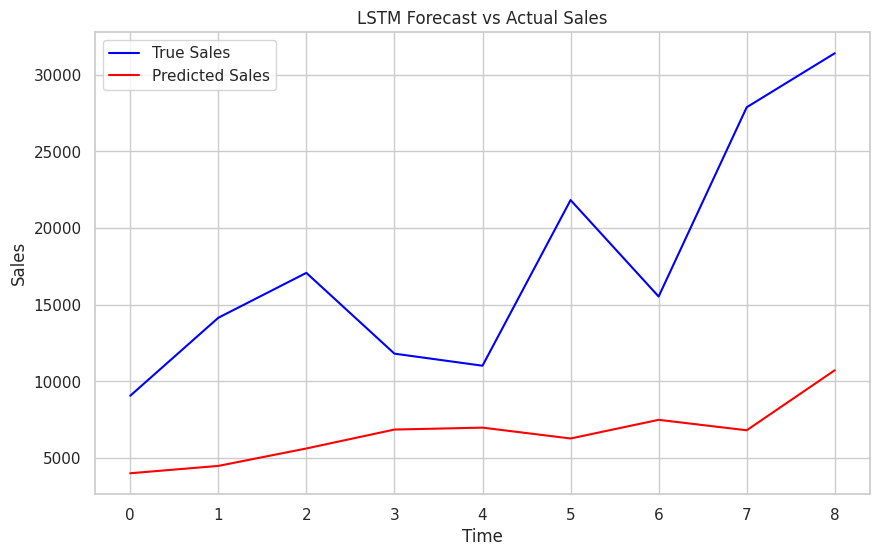

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convert 'Sales' column to numeric
mdf['Sales'] = mdf['Sales'].replace(',', '', regex=True).astype(float)

# Prepare data for LSTM
def prepare_lstm_data(df, time_step=1):
    X, y = [], []
    for i in range(len(df) - time_step):
        X.append(df['Sales'].iloc[i:i + time_step].values)  # Taking the 'Sales' column
        y.append(df['Sales'].iloc[i + time_step])  # Target: the next value of 'Sales'
    return np.array(X), np.array(y)

# Set time steps
time_steps = 3  # Adjust based on data pattern

X, y = prepare_lstm_data(mdf, time_steps)

# Reshape X to be 3D [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1)

# Forecast
forecast_lstm = model.predict(X_test)

# Evaluate the model
mae_lstm = mean_absolute_error(y_test, forecast_lstm)
mse_lstm = mean_squared_error(y_test, forecast_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2 = r2_score(y_test, forecast_lstm)  # Corrected R² calculation

print(f"LSTM Model - MAE: {mae_lstm}, MSE: {mse_lstm}, RMSE: {rmse_lstm}, R²: {r2}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Sales', color='blue')
plt.plot(forecast_lstm, label='Predicted Sales', color='red')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('LSTM Forecast vs Actual Sales')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Assuming y_test is the true values and forecast_lstm is the predicted values from LSTM
r2 = r2_score(y_test, forecast_lstm)
print(f"R²: {r2}")



R²: -2.06024020367062


In [ ]:
mdf

Sales  time  Rolling_Mean  Rolling_Std  Month  Year       Date
month                                                                        
2014-01-01  3,668.70     0           NaN          NaN      1  2014 2014-01-01
2014-02-01  1,839.66     1           NaN          NaN      2  2014 2014-02-01
2014-03-01 14,573.96     2           NaN          NaN      3  2014 2014-03-01
2014-04-01  7,944.84     3           NaN          NaN      4  2014 2014-04-01
2014-05-01  6,912.79     4           NaN          NaN      5  2014 2014-05-01
2014-06-01 11,204.27     5           NaN          NaN      6  2014 2014-06-01
2014-07-01 10,821.05     6           NaN          NaN      7  2014 2014-07-01
2014-08-01  7,320.35     7           NaN          NaN      8  2014 2014-08-01
2014-09-01 17,682.37     8           NaN          NaN      9  2014 2014-09-01
2014-10-01 12,304.25     9           NaN          NaN     10  2014 2014-10-01
2014-11-01 17,557.03    10           NaN          NaN     11  2014 2014-11-01
2014-12-01 21,982.80    11     11,151.00     6,028.60     12  2014 2014-12-01
2015-01-01  4,638.38    12     11,231.81     5,924.79      1  2015 2015-01-01
2015-02-01  3,134.37    13     11,339.70     5,747.34      2  2015 2015-02-01
2015-03-01  9,106.10    14     10,884.05     5,684.02      3  2015 2015-03-01
2015-04-01 10,475.70    15     11,094.95     5,611.53      4  2015 2015-04-01
2015-05-01  6,807.11    16     11,086.15     5,618.77      5  2015 2015-05-01
2015-06-01  7,714.18    17     10,795.31     5,701.82      6  2015 2015-06-01
2015-07-01 11,743.38    18     10,872.17     5,708.41      7  2015 2015-07-01
2015-08-01  9,638.59    19     11,065.36     5,615.75      8  2015 2015-08-01
2015-09-01 16,956.97    20     11,004.91     5,541.46      9  2015 2015-09-01
2015-10-01  9,573.19    21     10,777.32     5,539.33     10  2015 2015-10-01
2015-11-01 23,854.61    22     11,302.12     6,461.58     11  2015 2015-11-01
2015-12-01 16,491.83    23     10,844.53     5,796.67     12  2015 2015-12-01
2016-01-01  7,622.74    24     11,093.23     5,565.62      1  2016 2016-01-01
2016-02-01  3,925.55    25     11,159.16     5,466.57      2  2016 2016-02-01
2016-03-01 12,801.09    26     11,467.08     5,444.43      3  2016 2016-03-01
2016-04-01 13,212.09    27     11,695.11     5,456.42      4  2016 2016-04-01
2016-05-01  9,339.43    28     11,906.14     5,296.83      5  2016 2016-05-01
2016-06-01 13,070.57    29     12,352.50     5,134.67      6  2016 2016-06-01
2016-07-01 10,638.44    30     12,260.43     5,156.45      7  2016 2016-07-01
2016-08-01  9,596.18    31     12,256.89     5,158.42      8  2016 2016-08-01
2016-09-01 24,866.62    32     12,916.03     6,211.45      9  2016 2016-09-01
2016-10-01 11,872.58    33     13,107.64     6,133.94     10  2016 2016-10-01
2016-11-01 25,698.02    34     13,261.26     6,442.85     11  2016 2016-11-01
2016-12-01 30,160.30    35     14,400.30     8,068.94     12  2016 2016-12-01
2017-01-01  5,964.03    36     14,262.08     8,208.60      1  2017 2017-01-01
2017-02-01  6,866.34    37     14,507.14     7,910.43      2  2017 2017-02-01
2017-03-01 10,893.44    38     14,348.17     7,966.80      3  2017 2017-03-01
2017-04-01  9,065.96    39     14,002.66     8,109.19      4  2017 2017-04-01
2017-05-01 14,153.64    40     14,403.84     7,975.50      5  2017 2017-05-01
2017-06-01 17,082.71    41     14,738.19     7,998.59      6  2017 2017-06-01
2017-07-01 11,813.02    42     14,836.07     7,950.90      7  2017 2017-07-01
2017-08-01 11,025.70    43     14,955.20     7,875.61      8  2017 2017-08-01
2017-09-01 21,831.40    44     14,702.26     7,571.21      9  2017 2017-09-01
2017-10-01 15,539.79    45     15,007.86     7,520.45     10  2017 2017-10-01
2017-11-01 27,884.21    46     15,190.05     7,823.34     11  2017 2017-11-01
2017-12-01 31,407.47    47     15,293.98     8,045.43     12  2017 2017-12-01

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 38, number of used features: 0
[LightGBM] [Info] Start training from score 11831.064594
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

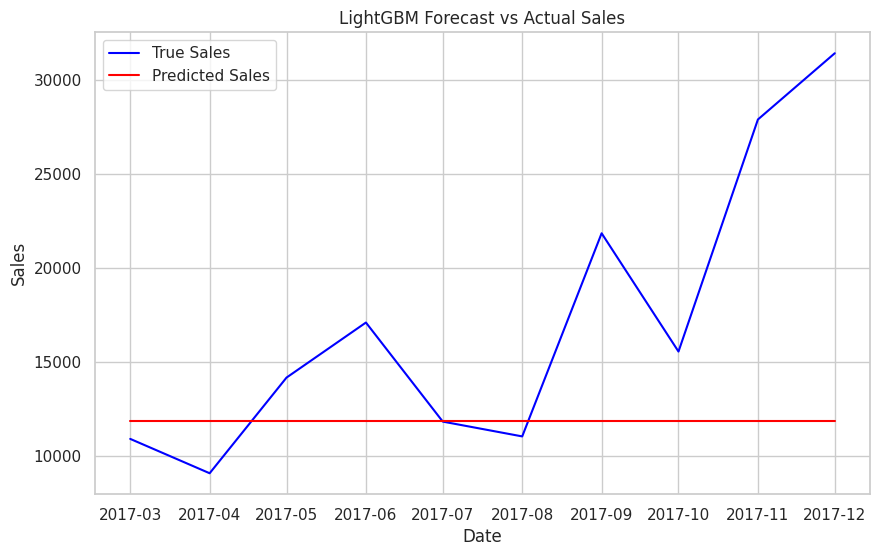

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 38, number of used features: 0
[LightGBM] [Info] Start training from score 11831.064594
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

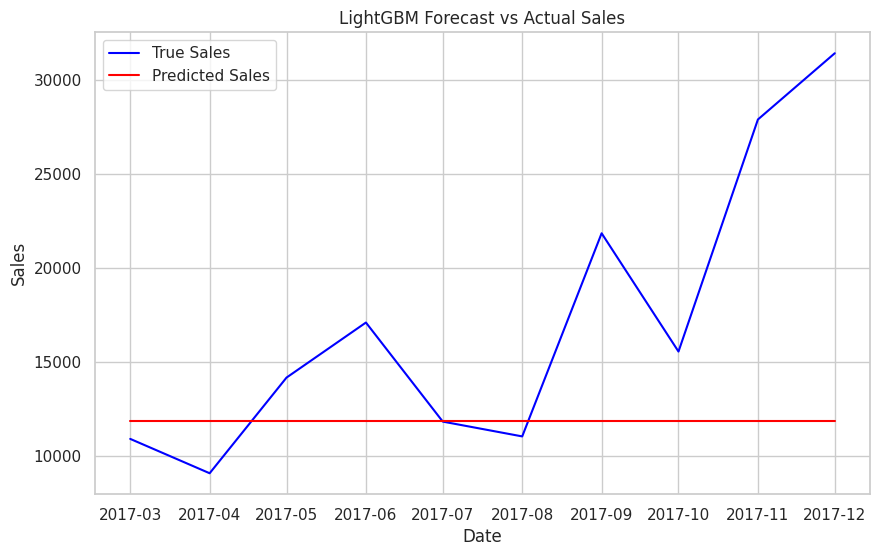

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Prepare data for LightGBM
X = mdf[[ 'Month', 'Year']]
y = mdf['Sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LightGBM model
model_lgb = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05)
model_lgb.fit(X_train, y_train)

# Make predictions
forecast_lgb = model_lgb.predict(X_test)

# Evaluate the model
mae_lgb = mean_absolute_error(y_test, forecast_lgb)
mse_lgb = mean_squared_error(y_test, forecast_lgb)
rmse_lgb = np.sqrt(mse_lgb)
r2 = r2_score(y_test, y_pred)  # R² score

print(f"LightGBM Model - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")



# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Sales', color='blue')
plt.plot(y_test.index, forecast_lgb, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('LightGBM Forecast vs Actual Sales')
plt.legend()
plt.show()
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Prepare data for LightGBM
X = mdf[[ 'Month', 'Year']]
y = mdf['Sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LightGBM model
model_lgb = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05)
model_lgb.fit(X_train, y_train)

# Make predictions
forecast_lgb = model_lgb.predict(X_test)

# Evaluate the model
mae_lgb = mean_absolute_error(y_test, forecast_lgb)
mse_lgb = mean_squared_error(y_test, forecast_lgb)
rmse_lgb = np.sqrt(mse_lgb)

print(f"LightGBM Model - MAE: {mae_lgb}, MSE: {mse_lgb}, RMSE: {rmse_lgb}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Sales', color='blue')
plt.plot(y_test.index, forecast_lgb, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('LightGBM Forecast vs Actual Sales')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Assuming y_test is the true values and y_pred is the predicted values for each model
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")


R²: 0.7619261140052537


ARIMA + Random Forest Model - MAE: 3011.2967485999916, MSE: 12760622.422302669, RMSE: 3572.2013412324154, R²: 0.7557363159978026
Improvement over Baseline - MAE Difference: 3132.599246663166
Improvement over Baseline - MSE Difference: 66924211.49591922
Improvement over Baseline - RMSE Difference: 5354.434862748449
Improvement over Baseline - R² Difference: -1.2810624676398488


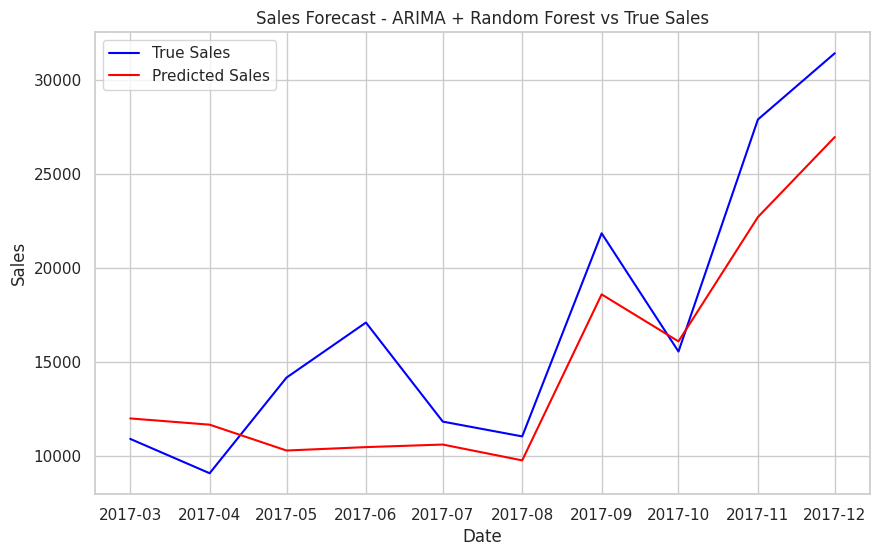

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load and preprocess the data (assuming mdf is the dataset)
df = mdf.copy()

# Prepare the data for ARIMA + Random Forest Model
# Use 'Sales' as target variable, and 'Month', 'Year' as potential features
# Create a new dataframe with ARIMA predictions and features for Random Forest
df_arima = df[['Month', 'Year', 'Sales']].copy()

# Fit ARIMA model for trend forecasting
arima_model = ARIMA(df_arima['Sales'], order=(1, 1, 1))  # ARIMA model (p, d, q)
arima_model_fit = arima_model.fit()

# Get the ARIMA predicted values
arima_pred = arima_model_fit.predict(start=0, end=len(df_arima)-1, dynamic=False)

# Add ARIMA predictions to the dataframe as a feature
df_arima['arima_pred'] = arima_pred

# Prepare data for Random Forest model
X = df_arima[['Month', 'Year', 'arima_pred']]  # Features (ARIMA predictions as a feature)
y = df_arima['Sales']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Model evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"ARIMA + Random Forest Model - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")

# Compare predictions to baseline (if needed)
baseline_pred = np.mean(y_train)  # Predict the mean of training sales for the test set
baseline_mae = mean_absolute_error(y_test, [baseline_pred] * len(y_test))
baseline_mse = mean_squared_error(y_test, [baseline_pred] * len(y_test))
baseline_rmse = np.sqrt(baseline_mse)
baseline_r2 = r2_score(y_test, [baseline_pred] * len(y_test))

print(f"Improvement over Baseline - MAE Difference: {baseline_mae - mae}")
print(f"Improvement over Baseline - MSE Difference: {baseline_mse - mse}")
print(f"Improvement over Baseline - RMSE Difference: {baseline_rmse - rmse}")
print(f"Improvement over Baseline - R² Difference: {baseline_r2 - r2}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Sales', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast - ARIMA + Random Forest vs True Sales')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Bayesian Ridge + DNN Model - MAE: 6094.858019736586, MSE: 57002982.109716654, RMSE: 7550.031927728296, R²: -0.0911504116676296


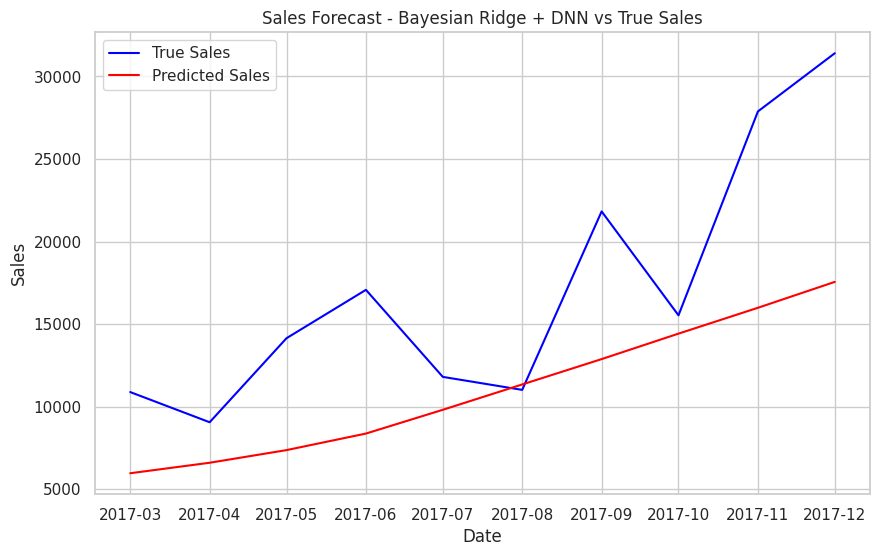

In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Assuming mdf is your dataframe
X = mdf[['Month', 'Year']]  # Features
y = mdf['Sales']  # Target Variable

# Scale the features for DNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Bayesian Ridge Regression
bayesian_model = BayesianRidge()
bayesian_model.fit(X_train, y_train)

# Predict with Bayesian Ridge
y_train_bayesian_pred = bayesian_model.predict(X_train)
y_test_bayesian_pred = bayesian_model.predict(X_test)

# Deep Neural Network Model
dnn_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000)
dnn_model.fit(X_train, y_train)

# Predict with DNN
y_train_dnn_pred = dnn_model.predict(X_train)
y_test_dnn_pred = dnn_model.predict(X_test)

# Combine predictions from Bayesian Ridge and DNN
y_test_combined_pred = (y_test_bayesian_pred + y_test_dnn_pred) / 2

# Evaluation
mae = mean_absolute_error(y_test, y_test_combined_pred)
mse = mean_squared_error(y_test, y_test_combined_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_combined_pred)  # R² calculation

print(f"Bayesian Ridge + DNN Model - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Sales', color='blue')
plt.plot(y_test.index, y_test_combined_pred, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast - Bayesian Ridge + DNN vs True Sales')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA + XGBoost Model - MAE: 3185.1939467791985, MSE: 15764410.359726619, RMSE: 3970.4420861821695, R²: 0.6982378427043552


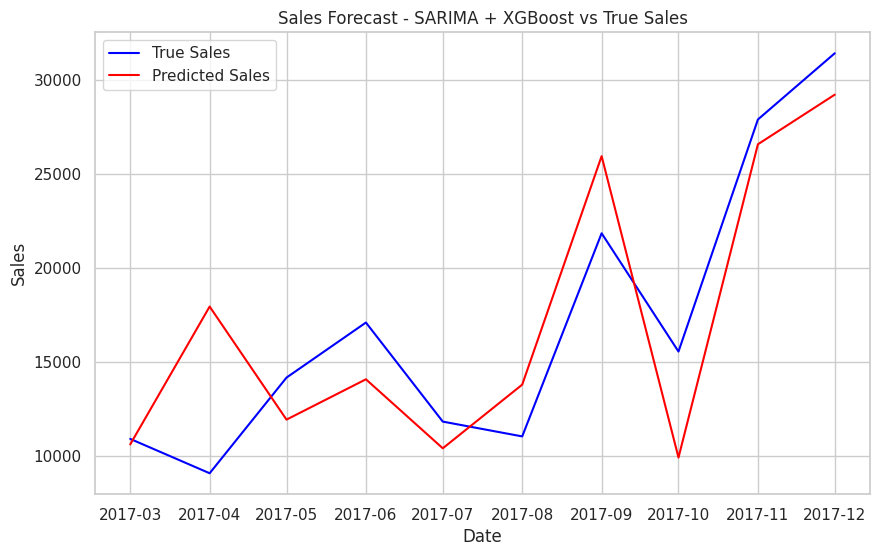

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# Data Preprocessing
X = mdf[['Month', 'Year']]  # Features
y = mdf['Sales']  # Target Variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# SARIMA Model
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  # Adjust SARIMA parameters for best fit
sarima_model_fit = sarima_model.fit()

# Forecast using SARIMA
y_train_sarima_pred = sarima_model_fit.predict(start=0, end=len(y_train)-1)
y_test_sarima_pred = sarima_model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# Train XGBoost Model on Residuals (for non-seasonal influences)
rf_model = xgb.XGBRegressor(objective='reg:squarederror')
rf_model.fit(X_train, y_train - y_train_sarima_pred)

# Predict using XGBoost
y_test_rf_pred = rf_model.predict(X_test)

# Combine SARIMA and XGBoost predictions
y_test_combined_pred = y_test_sarima_pred + y_test_rf_pred

# Evaluation
mae = mean_absolute_error(y_test, y_test_combined_pred)
mse = mean_squared_error(y_test, y_test_combined_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_combined_pred)  # R² calculation

print(f"SARIMA + XGBoost Model - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Sales', color='blue')
plt.plot(y_test.index, y_test_combined_pred, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast - SARIMA + XGBoost vs True Sales')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ARIMA + XGBoost Model - MAE: 3249.3123800338735, MSE: 14640469.036109218, RMSE: 3826.286585726325, R²: 0.7197523142734898


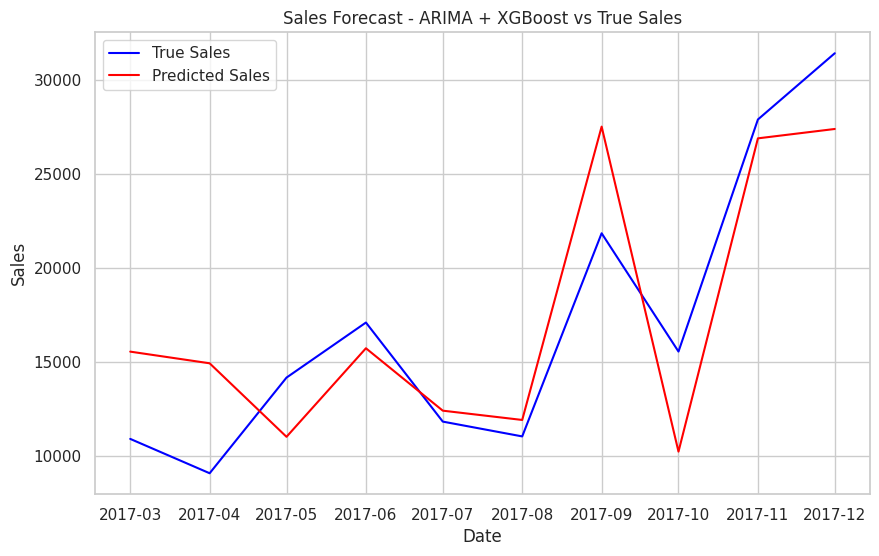

In [ ]:
from statsmodels.tsa.arima.model import ARIMA  # Use ARIMA instead of SARIMAX
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# Data Preprocessing
X = mdf[['Month', 'Year']]  # Features
y = mdf['Sales']  # Target Variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ARIMA Model
arima_model = ARIMA(y_train, order=(1, 1, 1))  # ARIMA(p, d, q) - Adjust parameters for best fit
arima_model_fit = arima_model.fit()

# Forecast using ARIMA
y_train_arima_pred = arima_model_fit.predict(start=0, end=len(y_train)-1, typ='levels')
y_test_arima_pred = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, typ='levels')

# Train XGBoost Model on Residuals (for non-seasonal influences)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train - y_train_arima_pred)

# Predict using XGBoost
y_test_xgb_pred = xgb_model.predict(X_test)

# Combine ARIMA and XGBoost predictions
y_test_combined_pred = y_test_arima_pred + y_test_xgb_pred

# Evaluation
mae = mean_absolute_error(y_test, y_test_combined_pred)
mse = mean_squared_error(y_test, y_test_combined_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_combined_pred)  # R² calculation

print(f"ARIMA + XGBoost Model - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Sales', color='blue')
plt.plot(y_test.index, y_test_combined_pred, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast - ARIMA + XGBoost vs True Sales')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 38, number of used features: 0
[LightGBM] [Info] Start training from score 1934.089771
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

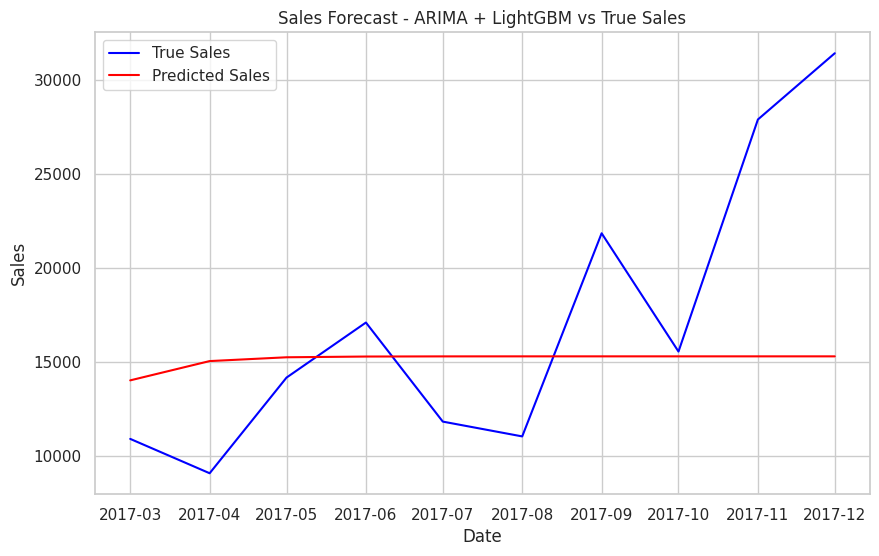

In [ ]:
from statsmodels.tsa.arima.model import ARIMA  # Use ARIMA instead of SARIMAX
import lightgbm as lgb  # Import LightGBM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# Data Preprocessing
X = mdf[['Month', 'Year']]  # Features
y = mdf['Sales']  # Target Variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ARIMA Model
arima_model = ARIMA(y_train, order=(1, 1, 1))  # ARIMA(p, d, q) - Adjust parameters for best fit
arima_model_fit = arima_model.fit()

# Forecast using ARIMA
y_train_arima_pred = arima_model_fit.predict(start=0, end=len(y_train)-1, typ='levels')
y_test_arima_pred = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, typ='levels')

# Train LightGBM Model on Residuals (for non-seasonal influences)
lgb_model = lgb.LGBMRegressor(objective='regression')  # LightGBM model
lgb_model.fit(X_train, y_train - y_train_arima_pred)

# Predict using LightGBM
y_test_lgb_pred = lgb_model.predict(X_test)

# Combine ARIMA and LightGBM predictions
y_test_combined_pred = y_test_arima_pred + y_test_lgb_pred

# Evaluation
mae = mean_absolute_error(y_test, y_test_combined_pred)
mse = mean_squared_error(y_test, y_test_combined_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_combined_pred)  # R² calculation

print(f"ARIMA + LightGBM Model - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Sales', color='blue')
plt.plot(y_test.index, y_test_combined_pred, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast - ARIMA + LightGBM vs True Sales')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ARIMA + AdaBoost Model - MAE: 3149.799290758968, MSE: 14217933.846078891, RMSE: 3770.6675597404355, R²: 0.7278404779007583


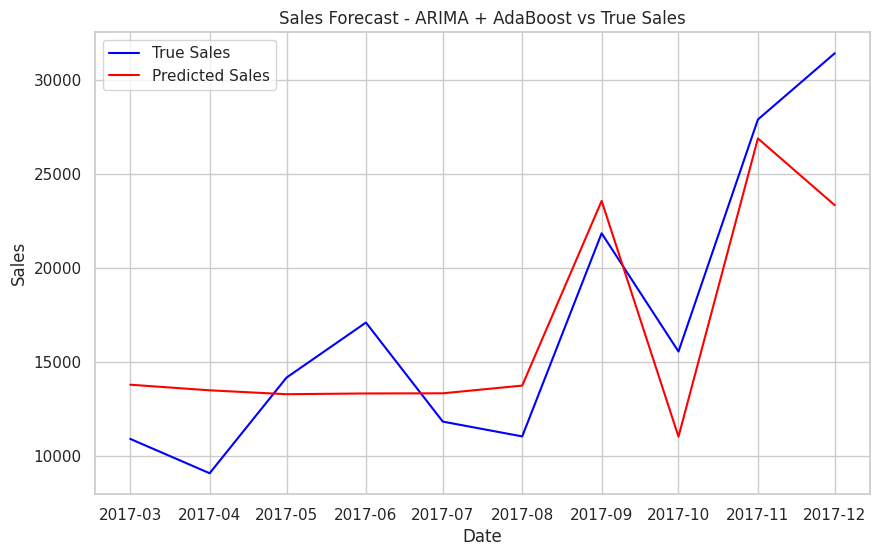

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import AdaBoostRegressor  # Import AdaBoost
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor  # Base model for AdaBoost

# Data Preprocessing
X = mdf[['Month', 'Year']]  # Features
y = mdf['Sales']  # Target Variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ARIMA Model
arima_model = ARIMA(y_train, order=(1, 1, 1))  # Adjust (p, d, q) parameters for best fit
arima_model_fit = arima_model.fit()

# Forecast using ARIMA
y_train_arima_pred = arima_model_fit.predict(start=0, end=len(y_train)-1, typ='levels')
y_test_arima_pred = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, typ='levels')

# Train AdaBoost Model on Residuals
ada_model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3), n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train - y_train_arima_pred)  # Learn residuals


# Predict using AdaBoost
y_test_ada_pred = ada_model.predict(X_test)

# Combine ARIMA and AdaBoost predictions
y_test_combined_pred = y_test_arima_pred + y_test_ada_pred

# Evaluation
mae = mean_absolute_error(y_test, y_test_combined_pred)
mse = mean_squared_error(y_test, y_test_combined_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_combined_pred)  # R² calculation

print(f"ARIMA + AdaBoost Model - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Sales', color='blue')
plt.plot(y_test.index, y_test_combined_pred, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast - ARIMA + AdaBoost vs True Sales')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA + AdaBoost Model - MAE: 3294.83174803047, MSE: 15813043.79190042, RMSE: 3976.5618053665935, R²: 0.6973069021189116


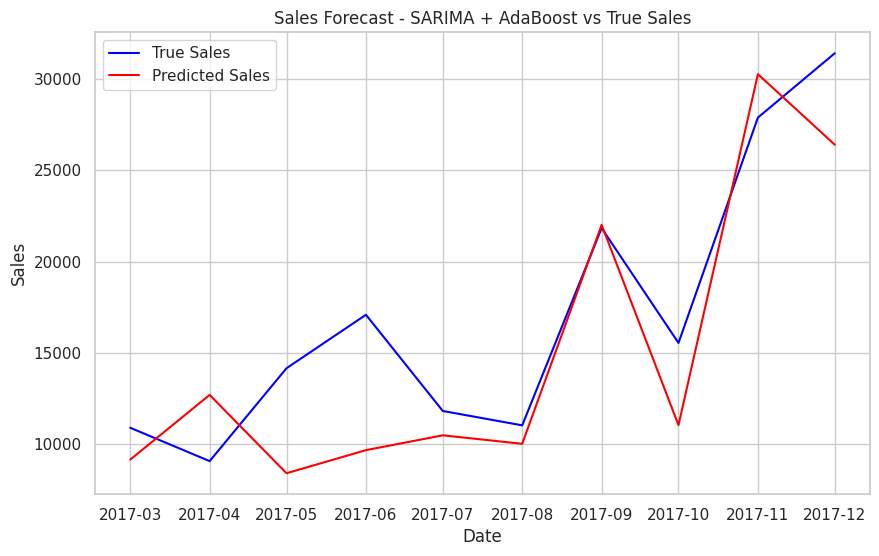

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Import SARIMA
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor  # Base model for AdaBoost

# Data Preprocessing
X = mdf[['Month', 'Year']]  # Features
y = mdf['Sales']  # Target Variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# SARIMA Model (Seasonal ARIMA)
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  # Adjust parameters based on seasonality
sarima_model_fit = sarima_model.fit()

# Forecast using SARIMA
y_train_sarima_pred = sarima_model_fit.predict(start=0, end=len(y_train)-1, typ='levels')
y_test_sarima_pred = sarima_model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, typ='levels')

# Train AdaBoost Model on Residuals
ada_model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3), n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train - y_train_sarima_pred)  # Learn residuals

# Predict using AdaBoost
y_test_ada_pred = ada_model.predict(X_test)

# Combine SARIMA and AdaBoost predictions
y_test_combined_pred = y_test_sarima_pred + y_test_ada_pred

# Evaluation
mae = mean_absolute_error(y_test, y_test_combined_pred)
mse = mean_squared_error(y_test, y_test_combined_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_combined_pred)

print(f"SARIMA + AdaBoost Model - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Sales', color='blue')
plt.plot(y_test.index, y_test_combined_pred, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast - SARIMA + AdaBoost vs True Sales')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA + Random Forest Model - MAE: 3265.9614124972504, MSE: 15962101.421889808, RMSE: 3995.259869131144, R²: 0.694453642722551


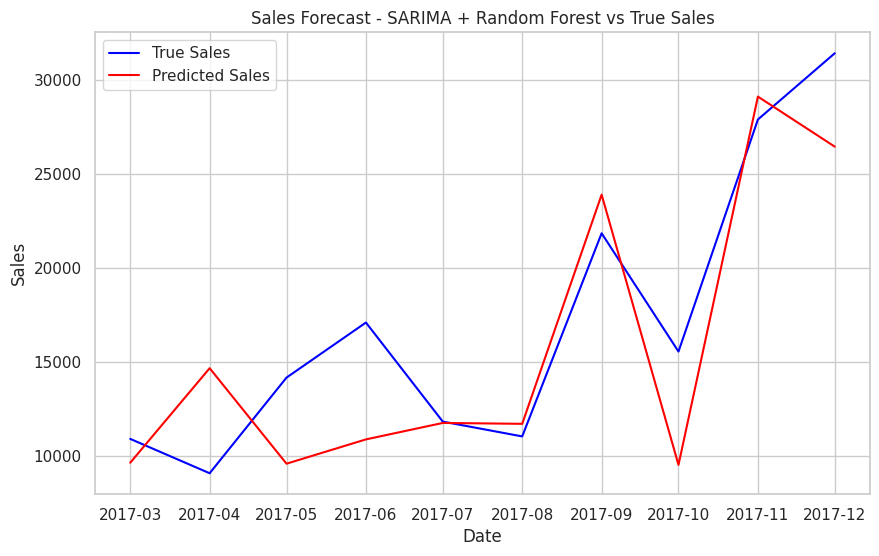

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# Data Preprocessing
X = mdf[['Month', 'Year']]
y = mdf['Sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# SARIMA Model
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit()

# Forecast using SARIMA
y_train_sarima_pred = sarima_model_fit.predict(start=0, end=len(y_train)-1, typ='levels')
y_test_sarima_pred = sarima_model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, typ='levels')

# Train Random Forest on Residuals
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train - y_train_sarima_pred)

# Predict using Random Forest
y_test_rf_pred = rf_model.predict(X_test)

# Combine SARIMA and Random Forest predictions
y_test_combined_pred = y_test_sarima_pred + y_test_rf_pred

# Evaluation Metrics
mae_rf = mean_absolute_error(y_test, y_test_combined_pred)
mse_rf = mean_squared_error(y_test, y_test_combined_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_test_combined_pred)

# Print Results
print(f"SARIMA + Random Forest Model - MAE: {mae_rf}, MSE: {mse_rf}, RMSE: {rmse_rf}, R²: {r2_rf}")

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Sales', color='blue')
plt.plot(y_test.index, y_test_combined_pred, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast - SARIMA + Random Forest vs True Sales')
plt.legend()
plt.show()


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 38, number of used features: 0
[LightGBM] [Info] Start training from score -63.111842
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

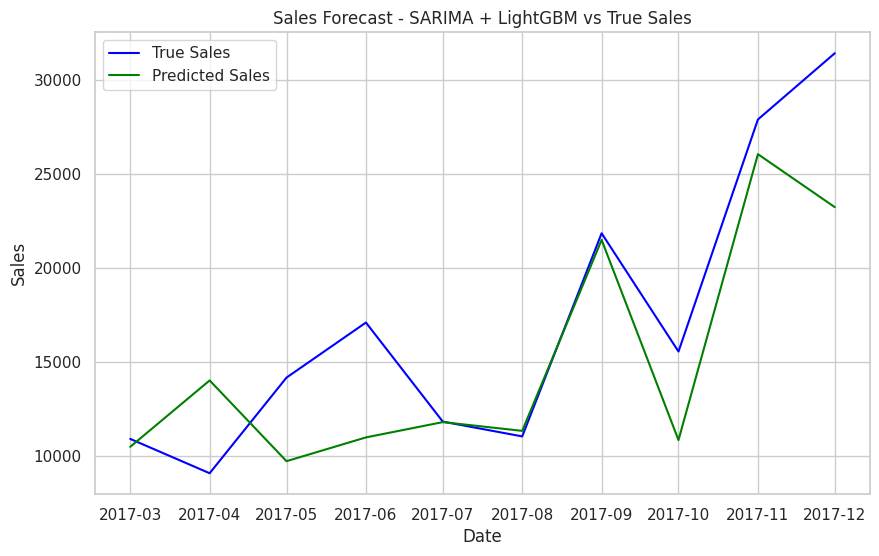

In [ ]:
import lightgbm as lgb

# Train LightGBM on Residuals
lgb_model = lgb.LGBMRegressor(objective='regression', n_estimators=100, learning_rate=0.05)
lgb_model.fit(X_train, y_train - y_train_sarima_pred)

# Predict using LightGBM
y_test_lgb_pred = lgb_model.predict(X_test)

# Combine SARIMA and LightGBM predictions
y_test_combined_pred_lgb = y_test_sarima_pred + y_test_lgb_pred

# Evaluation Metrics
mae_lgb = mean_absolute_error(y_test, y_test_combined_pred_lgb)
mse_lgb = mean_squared_error(y_test, y_test_combined_pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_test_combined_pred_lgb)

# Print Results
print(f"SARIMA + LightGBM Model - MAE: {mae_lgb}, MSE: {mse_lgb}, RMSE: {rmse_lgb}, R²: {r2_lgb}")

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Sales', color='blue')
plt.plot(y_test.index, y_test_combined_pred_lgb, label='Predicted Sales', color='green')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast - SARIMA + LightGBM vs True Sales')
plt.legend()
plt.show()
